In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec


In [40]:
# This notebook will define information gain and brier score
# We will generate a synthetic time series of a rare event - forecast-observation pairs for a sequence of time samples
# Two forecasting systems give probabilistic occurrence of this rare event
# There's an old (worse) and new (better) model so we can compute the gain (or loss) in information and Brier Score 
# Both models are overconfident and under-predict the rare event

# We ignore observational error with the observations 0 or 1
# Forecasts are between 0 and 1 (probability) but never 0 or 1 due to it breaking logarithms

# There are 100,000 forecast-observation pairs from these fake models for the same event time series
# This is a column called "o"
# The old model's forecast is in a column called "f_old"
# The new model's forecast is in a column called "f_new"
# The model forecasts are roughly correlated with the observations so we have a realistic reliability diagram
# There is more variation in the f_old forecasts than the f_new forecasts so the reliability diagram is more curved for the old model
# The old model is more overconfident than the new model so the old model has a higher Brier Score and lower information gain

# Assuming the observation array 'o' is defined
# Predefined set of forecast probabilities
p_k = np.array([0.005,0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99,0.995])
# We use "ks" in the class notation for the bins, but p_k in the code.
# TODO: unify this 
ks = p_k 
rng = np.random.default_rng(27)
N = int(1E5)  # Number of forecast-observation pairs
base_rate = 0.005
# Setting the error too low might actually cause lower skill - can check sensitivity TODO!
error_old_f = 0.1
error_new_f = 0.03
autocorr = 0.8

# window length for plotting time series
nn = 35


In [41]:
class DKL:
    """
    This class is used to compute the Ignorance and Brier Score for two forecasting systems.
    Another function will compute information gain using one model or prior entropy (uncertainty component) as baseline
    It takes as input the forecasts and observations to compute various metrics.
    Brier Scores are included as components of the information-based methods
    """
    def __init__(self, f, o, binning_k):

        """
        Initialize the class with forecasts and observations pairs.

        Parameters:
        f (array-like): Forecasts
        o (array-like): Observations corresponding to the forecasts.
        binning_k (array-like): Probability bins for quantising the forecasts.        
        """
        self.f = f
        self.o = o

        # Probability bins
        if binning_k is None:
            # This might not work without interpolation to these default values
            # Also creates bins for 0 and 1!
            self.ks = np.linspace(0, 1, num=11)
        else:
            self.ks = binning_k
        
        # The number of total forecast-observation pairs
        self.N = len(self.o)

        # Base rate, o_bar, of event
        self.o_bar = np.nanmean(self.o)

        # Generate binning of forecasts and observations
        self.df = self.do_binning()

    def compute_ign(self):
        # Ignorance is just DKL - this is the method 
        ign = np.mean(self.compute_dkl(self.o, self.f))
        return ign

    @staticmethod
    def compute_dkl(q, p):
        """
        Compute the Kullback-Leibler divergence, handling edge cases explicitly.
        
        Parameters:
        q (float or array-like): True probabilities.
        p (float or array-like): Forecast probabilities.
        
        Returns:
        float or array-like: The Kullback-Leibler divergence, ensuring floating-point output.
        """
        # Ensure q and p are numpy arrays for element-wise operations
        q = np.asarray(q, dtype=float)
        p = np.asarray(p, dtype=float)
        
        # Initialize DKL with zeros in the same shape as q and p, explicitly using a floating-point type
        dkl = np.zeros_like(q, dtype=float)
        
        # Compute DKL for valid indices (where q != 0 and q != 1)
        valid_idx = (q != 0) & (q != 1)
        dkl[valid_idx] = q[valid_idx] * np.log2(q[valid_idx] / p[valid_idx]) + \
                         (1 - q[valid_idx]) * np.log2((1 - q[valid_idx]) / (1 - p[valid_idx]))
        
        # Handle edge cases: q == 0 or q == 1 specifically
        q_zero_idx = q == 0
        dkl[q_zero_idx] = (1 - q[q_zero_idx]) * np.log2((1 - q[q_zero_idx]) / (1 - p[q_zero_idx]))
        
        q_one_idx = q == 1
        dkl[q_one_idx] = q[q_one_idx] * np.log2(q[q_one_idx] / p[q_one_idx])
        
        # Set divergences to infinity where appropriate, now safe with dtype=float
        dkl[(p == 0) & (q > 0)] = np.inf
        dkl[(p == 1) & (q < 1)] = np.inf
        
        return dkl

    def compute_unc_ign(self):
        # Compute the entropy of the observations
        if self.o_bar == 0 or self.o_bar == 1:
            unc = 0
        else:
            unc = -(self.o_bar * np.log2(self.o_bar) + (1-self.o_bar) * np.log2(1-self.o_bar))
        return unc
    
    def compute_ignss(self):
        # IGNSS is the ignorance skill score
        # It is positive if the forecast is better than climatology and negative if it is worse
        ign = self.compute_ign()
        unc = self.compute_unc_ign()
        if unc == 0:
            return np.nan
        ignss = self.compute_skill_score(ign, unc)
        return ignss

    def do_binning(self):
        # Define bins for forecast probabilities
        bin_labels = self.ks
        # The bin edges should be the midpoints between the bin labels
        bin_edges = (bin_labels[:-1] + bin_labels[1:]) / 2
        # bin_labels = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins as labels

        # Categorize each forecast into a bin
        f_bin_indices = np.digitize(self.f, bin_edges, right=False) 
        # Initialize counters for each bin
        n_k = np.zeros_like(bin_labels)
        o_k = np.zeros_like(bin_labels)

        # Populate n_k and o_k
        for i, label in enumerate(bin_labels):
            # Indices where forecasts fall into the current bin
            in_bin = f_bin_indices == i
            n_k[i] = np.sum(in_bin)
            o_k[i] = np.sum(self.o[in_bin])

        # Construct and return the DataFrame
        bins_df = pd.DataFrame({
            'k': np.arange(len(bin_labels)),
            'p_k': bin_labels,
            'o_k': o_k,
            'n_k': n_k
        })

        return bins_df

    def compute_rel_ign(self):
        total_dkl = 0
        # Iterate over each row in the DataFrame
        for _, row in self.df.iterrows():
            p_k = row['p_k']  # Probability forecast for the bin
            o_k = row['o_k']  # Number of observations of the event in this bin
            n_k = row['n_k']  # Number of forecasts in this bin
            
            # Ensure non-zero n_k to avoid division by zero
            if n_k > 0:
                ok_bar = o_k / n_k  # Observed frequency of the event in this bin
                # Compute DKL using the observed frequency and the forecast probability
                dkl = self.compute_dkl(ok_bar, p_k)
                total_dkl += dkl * n_k
    
        # Return the total DKL divided by the total number of observations
        return total_dkl / self.N

    def compute_res_ign(self):
        total_dkl = 0
        # Overall observed frequency of the event
        o_bar = np.sum(self.df['o_k']) / self.N
    
        # Iterate over each row in the DataFrame
        for _, row in self.df.iterrows():
            p_k = row['p_k']  # Probability forecast for the bin
            o_k = row['o_k']  # Number of observations of the event in this bin
            n_k = row['n_k']  # Number of forecasts in this bin
    
            # Ensure non-zero n_k to avoid division by zero
            if n_k > 0:
                ok_bar = o_k / n_k  # Observed frequency of the event in this bin
                # Compute DKL using the observed frequency and the overall observed frequency
                dkl = self.compute_dkl(ok_bar, o_bar)
                total_dkl += dkl * n_k
    
        # Return the total DKL divided by the total number of observations
        return total_dkl / self.N

    def compute_unc_bs(self):
        return self.o_bar * (1 - self.o_bar)

    def compute_bs(self):
        # Compute brier score for self.o and self.f
        bs = np.nanmean(self.compute_bs_ts(self.o,self.f))
        return bs
    
    @staticmethod
    def compute_bs_ts(o,f):
        # Compute brier score for each time step
        bs = (o - f)**2
        return bs

    def compute_bss(self):
        # Compute brier score skill score
        bs = self.compute_bs()
        unc_bs = self.compute_unc_bs()
        bss = self.compute_skill_score(bs, unc_bs)
        # bss = (bs - unc_bs) / (0-unc_bs)
        return bss
    
    @staticmethod
    def compute_skill_score(f, b):
        # Compute the skill score of with "f" being forecast and "b" baseline
        # Positive means 'f' is better than 'b'
        # Negative means forecast model has less skill than the baseline
        # ss = (f-b)/(0-b)
        ss = 1 - (f/b) 
        return ss
    
    def ign_from_components(self, prints=False):
        rel = self.compute_rel_ign()
        res = self.compute_res_ign()
        unc = self.compute_unc_ign()
        ign = unc + rel - res
        ignss = self.compute_skill_score(ign, unc)
        if prints:
            df = pd.DataFrame({
                'Reliability': [rel],
                'Resolution': [res],
                'Uncertainty': [unc],
                'Ignorance': [ign],
                'Ignorance Skill Score': [ignss]
            })
            return df 
        return ign
    
    def compute_components(self,prints=False):
        rel = self.compute_rel_ign()
        res = self.compute_res_ign()
        unc = self.compute_unc_ign()
        ign = self.compute_ign()
        brier = self.compute_bs()
        ignss = self.compute_ignss()
        bss = self.compute_bss()
        
        if prints:
        # Create a DataFrame for pretty printing
            df = pd.DataFrame({
                'Reliability': [rel],
                'Resolution': [res],
                'Uncertainty': [unc],
                'Ignorance': [ign],
                'Ignorance Skill Score': [ignss],
                'Brier Score': [brier],
                'Brier Skill Score': [bss]
            })
            # print(df)
            return df
        
        return rel, res, unc, ign, ignss, brier, bss
    
def calculate_info_gain(ign_baseline, ign_new):
    """
    Calculate the information gain between a baseline and a new forecast model.
    
    Parameters:
    - ign_baseline (float): Ignorance of the baseline forecast model.
    - ign_new (float): Ignorance of the new forecast model.
    
    Returns:
    - float: Information gain of the new forecast model over the baseline.
    """
    return ign_baseline - ign_new



In [42]:
def generate_time_series(rng, n=10000, storm_prob=0.01, forecast_error=0.01, autocorr=0.9, o=None):
    """
    Generates a time series for thunderstorm occurrence and probabilistic forecasts with improved correlation,
    using numpy's random number Generator for consistent reproducibility. Allows for an optional observed
    series 'o' to be provided.
    
    Parameters:
    - n (int): Length of the time series.
    - storm_prob (float): Probability of a thunderstorm occurring.
    - forecast_error (float): Standard deviation of the forecast error.
    - autocorr (float): Autocorrelation factor for both observed and forecasted series.
    - seed (int): Seed for the random number generator for reproducibility.
    - o (pandas.Series or None): Optional observed occurrence series. If None, 'o' is generated as per the original method.
    
    Returns:
    - DataFrame with columns 'f' for forecast probability and 'o' for observed occurrence (0 or 1).
    """   
    # if o is a pandas series or dataframe, make it numpy array 
    if isinstance(o, pd.Series) or isinstance(o, pd.DataFrame):
        o = o.to_numpy()
    
    # Check if 'o' is provided, if not, generate 'o' as before
    if o is None:
        o = rng.random(n) < storm_prob
        o = np.round(o).astype(int)  # Ensure binary outcomes

        # Introduce autocorrelation in observations
        for i in range(1, n):
            if rng.random() < autocorr:
                o[i] = o[i-1]
    else:
        # Ensure 'o' is a binary series as expected
        o = o.astype(int)
        n = len(o)  # Update 'n' based on the length of provided 'o'

    f = np.zeros(n)  # Initialize forecast probabilities array

    # Adjust initial forecast based on observations
    for i in range(1, n):
        base_forecast = storm_prob if o[i-1] == 0 else 1 - storm_prob if isinstance(o, pd.Series) else storm_prob if o[i-1] == 0 else 1 - storm_prob
        adjustment = rng.normal() * forecast_error
        
        # Incorporate autocorrelation in forecasts
        if rng.random() < autocorr and i > 1:
            f[i] = f[i-1] + adjustment
        else:
            f[i] = base_forecast + adjustment

        # Ensure forecasts are within [0, 1] range
        f[i] = np.clip(f[i], 0, 1)

    df = pd.DataFrame({'f': f, 'o': o})
    
    return df


In [43]:
def quantise_forecasts(df, bins):
    """
    Quantises forecast probabilities into specified bins. Ensures 0% goes into the "0.005" bin and 100%
    goes into the "0.995" bin, with the rest following the specified bins.
    
    Parameters:
    - df (DataFrame): DataFrame containing 'f' column for forecast probabilities.
    - bins (tuple): Tuple of probability bins.
    
    Returns:
    - DataFrame with quantised forecast probabilities in 'f_quantised' column.
    """
    print("Max and min of forecast probabilities in df dataframe for 'f' column")
    print(df['f'].max(), df['f'].min())
       
    
    # Correct handling for 0% and 100% forecasts to align with the nearest bins
    df['f'] = np.where(df['f'] <= 0, 0.005, df['f'])  # Adjust to 0.005 for 0%
    df['f'] = np.where(df['f'] >= 1, 0.995, df['f'])  # Adjust to 0.995 for 100%

    bins = np.array(bins)  # Ensure bins is a numpy array for digitize function

    # Find the index of the closest bin for each forecast, after handling 0% and 100% cases
    idx = np.digitize(df['f'], bins, right=True)  # Consider if right=True aligns with desired binning behavior

    # Replace forecast probabilities with bin labels, ensuring adjustments for 0 and 1 are considered
    df['f_quantised'] = bins[np.clip(idx - 1, 0, len(bins) - 1)]  # Adjust index and ensure it's within bounds
    
    return df


In [44]:
def plot_df_distr(df, p_k):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6), dpi=350)

    # Plot the observed frequency and number of forecasts for each bin
    ax.bar(p_k, df['o_k'], width=0.01, align='center', label='Observed', color='red', alpha=0.7)
    ax.bar(p_k, df['n_k'], width=0.01, align='center', label='Forecast', color='blue', alpha=0.7)

    # Set the title and labels
    ax.set_title('Observed Frequency and Number of Forecasts for Each Bin')
    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Frequency')
    ax.legend()

    # Show thin vertical lines at each unique value of p_k (forecast bins)
    for p in p_k:
        ax.axvline(p, color='black', alpha=0.2)

    # Display the plot
    plt.show()


In [45]:
def generate_and_quantise_time_series(n, storm_prob, forecast_error, autocorr, p_k, o=None, ax=None):
    """
    Generates a time series of forecast probabilities and observed occurrences, and quantises the forecasts
    into specified probability bins.

    Parameters:
    - n (int): Length of the time series.
    - storm_prob (float): Probability of a thunderstorm occurring.
    - forecast_error (float): Standard deviation of the forecast error.
    - autocorr (float): Autocorrelation factor for both observed and forecasted series.
    - p_k (array-like): Probability bins for quantising the forecasts.
    - ax (matplotlib.axes.Axes): The axes to draw on. If None, create a new figure and axes.

    Returns:
    - DataFrame with columns 'f' for forecast probability, 'o' for observed occurrence, and 'f_quantised' for quantised forecasts.
    """
    # Generate the time series
    df_raw = generate_time_series(rng, n, storm_prob, forecast_error, autocorr, o=o)

    # Quantise the forecasts
    df_quantised = quantise_forecasts(df_raw, p_k)

    # If no axes object is provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(7, 6), dpi=350)

    # Plot the quantised forecast probabilities on the second subplot
    sns.histplot(df_quantised['f_quantised'], bins=p_k, kde=False, ax=ax)
    ax.set_title('Quantised Forecast Probabilities')

    # label axes
    ax.set_xlabel("Probability")
    ax.set_ylabel("Count")

    plt.tight_layout()  # Adjust the padding between and around the subplots

    return df_raw, df_quantised

In [46]:
def plot_time_series(df, col, window_size):
    """
    Plots a time series of forecast probabilities and observed occurrences.
    
    Parameters:
    - df (DataFrame): DataFrame containing 'f' and 'o' columns.
    - window_size (int): Number of rows to plot around the first occurrence.
    """
    # Create a mini_df that subsets the df to a window around the 10th occurrence where df['o'] is 1
    # mini_df = ?
    event_indices = df[df['o'] == 1].index
    event_index = event_indices[9]  
    mini_df = df.iloc[event_index - window_size:event_index + window_size]

    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6), dpi=350)
    
    # Plot the forecast probabilities
    ax.plot(mini_df.index, mini_df[col], label='Forecast', color='blue')
    
    # Plot the observed occurrences
    ax.scatter(mini_df.index, mini_df['o'], label='Observation', color='red')
    
    # Set the title and labels
    ax.set_title('Time Series of Forecast Probabilities and Observations')
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability / Occurrence')
    ax.legend()
    
    ax.set_ylim(0, 1)
    
    # Show thin horizontal lines at each unique value of f_quantised (forecast bins)
    for p in p_k:
        ax.axhline(p, color='black', alpha=0.2)
        
    # Fill the graph area between y=0 and y=1 when the observation is 1 in red with a high alpha
    ax.fill_between(mini_df.index, 0, 1, where=mini_df['o'] == 1, color='red', alpha=0.1)
    
    # Display the plot
    plt.show()
    return
    

In [47]:
def plot_time_series_around_first_event(df, col, window_size, score="dkl", ax=None):
    """
    Plots a time series of forecast probabilities and observed occurrences.

    Parameters:
    - df (DataFrame): DataFrame containing 'f' and 'o' columns.
    - col (str): Column name to plot.
    - window_size (int): Number of rows to plot around the first occurrence.
    - score (str): Score to compute for the time series. Can be "dkl" or "brier".
    - ax (matplotlib.axes.Axes): The axes to draw on. If None, create a new figure and axes.
    """
    if score == "dkl":
        verif_ts = DKL.compute_dkl(df['o'],df[col])
    elif score == "brier":
        verif_ts = DKL.compute_bs_ts(df['o'],df[col])
    else:
        print("Score not recognised")
        raise Exception

    # Find the index of the first occurrence where df['o'] is 1
    event_index = df[df['o'] == 1].index[0]

    # Create a mini_df that subsets the df to a window around the first occurrence
    mini_df = df.iloc[event_index - window_size:event_index + window_size]

    # If no axes object is provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6), dpi=350)

    # Plot the forecast probabilities
    ax.plot(mini_df.index, mini_df[col], label='Forecast', color='blue')

    # Plot the observed occurrences
    ax.scatter(mini_df.index, mini_df['o'], label='Observation', color='red')

    # Set the title and labels
    ax.set_title('Time Series of Forecast Probabilities and Observations')
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability / Occurrence')

    ax.set_ylim(0, 1)

    # On a second axis, plot dkl_ts for the same time
    ax2 = ax.twinx()
    ax2.plot(mini_df.index, verif_ts[event_index - window_size:event_index + window_size], label=score, color='green', linestyle='--')
    # axis label is score + units (DKL is bits and Brier Score is probability - units are not shown)
    score_str = "Ignorance (bits)" if score == "dkl" else "Brier Score"
    ax2.set_ylabel(score_str, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Set legend for all three lines
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # Show thin horizontal lines at each unique value of f_quantised (forecast bins)
    for p in p_k:
        ax.axhline(p, color='black', alpha=0.2)

    # Fill the graph area between y=0 and y=1 when the observation is 1 in red with a high alpha
    ax.fill_between(mini_df.index, 0, 1, where=mini_df['o'] == 1, color='red', alpha=0.1)

    # Return the axes object
    return ax

In [83]:
def plot_model_stats_comparison(df_stats):
    """
    Plots a bar chart of reliability, resolution, ignorance, and ignorance skill score for new versus old models.

    Parameters:
    - df_stats (DataFrame): DataFrame containing the model statistics for comparison.
    """
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(13, 7), dpi=350)

    # Plot the bar chart
    df_stats.plot(kind='bar', ax=ax, width=0.8)

    # Set the title and labels
    plt.title('Model Statistics Comparison')
    plt.ylabel('Ignorance (bits) / Brier Score')

    # Set y-axis limits
    miny, maxy = (-0.5,0.35)
    plt.ylim(miny, maxy)

    # Annotate the bars with their respective values
    for p in ax.patches:
        height = p.get_height()
        if height > maxy:
            height = maxy/1.2
        elif height < miny:
            height = miny/1.2
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center',
                    va = 'center',
                    xytext = (0, 10),
                    textcoords = 'offset points')

    # Put the legend top right in three columns
    plt.legend(loc='upper right', ncol=3)

    # Label the x-axis with the model names
    ax.set_xticklabels(['Old', 'New'], rotation=0)

    # Display the plot
    plt.show()

In [49]:
def plot_histograms_on_same_axes(dkl_old, dkl_new, threshold, title, plot_poss_values=True):
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(12, 6), dpi=350)

    # Subset of DKL values for better visualization
    dkl_old_sub = dkl_old[dkl_old > threshold]
    dkl_new_sub = dkl_new[dkl_new > threshold]

    # Calculate the common bins for both histograms
    combined_data = np.concatenate([dkl_old_sub, dkl_new_sub])
    bins = np.histogram_bin_edges(combined_data, bins='auto')

    # Calculate histogram counts for old and new DKL values
    counts_old, _ = np.histogram(dkl_old_sub, bins=bins)
    counts_new, _ = np.histogram(dkl_new_sub, bins=bins)

    # Calculate the width of each bin
    bin_widths = np.diff(bins)

    # Plot the histograms side-by-side with adjusted bar widths
    bar_width_factor = 0.95  # Adjust this factor to change the bar width
    offset = bin_widths * bar_width_factor  # Calculate the offset for the second set of bars

    ax.bar(bins[:-1], counts_old, width=bin_widths * bar_width_factor, align='edge', alpha=0.7, color='blue', edgecolor='black', label='Old Model', zorder=2)
    ax.bar(bins[:-1] + offset, counts_new, width=bin_widths * bar_width_factor, align='edge', alpha=0.7, color='red', edgecolor='black', label='New Model', zorder=2)

    # Set the title and labels
    ax.set_title(f'{title} (Threshold: {threshold})')
    ax.set_xlabel('DKL (bits)')
    ax.set_ylabel('Frequency')
    ax.legend()

    if plot_poss_values:
        vlines = [y for y in -np.log2(p_k) if y > threshold]  # Assuming p_k is defined
        for v in vlines:
            ax.axvline(x=v, color='green', linestyle='--', label='Maximum DKL' if v == vlines[0] else "", zorder=1)
    
    # Increase zorder to ensure bars are on top
    ax.bar(bins[:-1], counts_old, width=bin_widths * bar_width_factor, align='edge', alpha=0.7, color='blue', edgecolor='black', label='Old Model', zorder=3)
    ax.bar(bins[:-1] + offset, counts_new, width=bin_widths * bar_width_factor, align='edge', alpha=0.7, color='red', edgecolor='black', label='New Model', zorder=3)


    # Set a logarithmic scale on the y-axis
    ax.set_yscale('log')

    # Display the plot
    plt.show()

In [77]:
def plot_time_series_multi_scores(df, col, window_size, scores):
    # Create a figure with two subplots (two rows, one column)
    fig, axs = plt.subplots(2, 1, figsize=(10, 12), dpi=350)

    # For each score in scores
    for i, score in enumerate(scores):
        # Plot the time series around the first event on the subplot
        plot_time_series_around_first_event(df, col, window_size, score=score, ax=axs[i])

        # Label the subplot
        score_str = "Ignorance (bits)" if score == "dkl" else "Brier Score"
        axs[i].set_title(f'({chr(97 + i)}) {score_str}')

    # Adjust the padding between and around the subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [51]:
def plot_histogram_with_insets(ig, bins=50, title='Histogram of information gained'):
    # Create the main figure and axes
    fig = plt.figure(figsize=(10, 6), dpi=350)
    gs = gridspec.GridSpec(4, 4)
    ax_main = plt.subplot(gs[0:4, 0:3])

    # Plot the main histogram
    n, bins, patches = ax_main.hist(ig, bins=bins, alpha=0.7, color='cyan', edgecolor='black')
    ax_main.set_title(title)
    ax_main.set_xlabel('Information Gain (bits)')
    ax_main.set_ylabel('Frequency')

    # Define the function to add the inset axis, annotate the Rectangle, and set the border color
    def add_inset(ax_main, gsp, xlim, color, ylim='auto', return_ylim=False, inset_y_side="left"):
        ax_inset = fig.add_subplot(gsp)
        ax_inset.hist(ig, bins=bins, alpha=0.7, color='cyan', edgecolor='black')
        ax_inset.set_xlim(xlim)  # Zoom into specified x-axis range

        # If ylim is not 'auto', set the y-axis range of the inset
        if ylim != 'auto':
            ax_inset.set_ylim(ylim)
        else:
            # Dynamically adjust the y-axis of the inset
            visible_bins = bins[(bins >= xlim[0]) & (bins <= xlim[1])]  # Bins that are within the zoomed-in range
            visible_n = n[(bins[:-1] >= xlim[0]) & (bins[:-1] <= xlim[1])]  # Frequency counts within the zoomed-in range
            ax_inset.set_ylim(0, max(visible_n) + np.sqrt(max(visible_n)))  # Add some space above the highest bar

        if inset_y_side == "right":            
            ax_inset.yaxis.tick_right()
        else:
            ax_inset.yaxis.tick_left()

        # Draw a rectangle on the main plot to indicate the zoomed area
        rect_x = xlim[0]
        rect_y = 0
        rect_width = xlim[1] - xlim[0]
        rect_height = ax_inset.get_ylim()[1]
        rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height, linewidth=3, edgecolor=color, facecolor='none')
        ax_main.add_patch(rect)

        # Set the border color of the inset axis
        for spine in ax_inset.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(2)
            
        if return_ylim:
            # return the y-axis for this inset 
            return ax_inset.get_ylim()

    # Add two insets: one for ig > 2 and another for ig < -2
    _ylim = add_inset(ax_main, gs[0:2, 2], [2, max(ig)], 'blue', return_ylim=True)
    # Use the y-axis range to set for the negative inset, as we want to find differences in the extreme bins 
    add_inset(ax_main, gs[0:2, 0], [min(ig), -2], 'red', ylim=_ylim, inset_y_side="right")

    ax_main.autoscale(axis='y', tight=False)
    plt.tight_layout()
    plt.show()


In [52]:
def plot_dkl_histogram(dkl_old, threshold, p_k, plot_poss_values=False):
    # Subset of DKL values for better visualization
    dkl_sub = dkl_old[dkl_old > threshold]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6), dpi=350)

    # Plot the histogram
    ax.hist(dkl_sub, bins='auto', alpha=0.7, color='blue', edgecolor='black')

    # Add the maximum possible DKL value with a vertical red line
    if plot_poss_values:
        vlines = [y for y in -np.log2(p_k) if y > threshold]
        for v in vlines:
            ax.axvline(x=v, color='red', linestyle='--', label='Maximum DKL')

    # Set the title and labels
    ax.set_title('Ignorance Histogram')
    ax.set_xlabel('Ignorance (bits)')
    ax.set_ylabel('Frequency')

    # Display the plot
    plt.show()
    


In [53]:
def plot_reliability(df, title='Reliability Diagram', ax=None):
    """
    Plots the reliability diagram for a given dataframe.

    Parameters:
    - df (DataFrame): DataFrame containing 'p_k', 'o_k', and 'n_k' columns.
    - title (str): Title of the plot.
    - ax (matplotlib.axes.Axes): The axes to draw on. If None, create a new figure and axes.

    Returns:
    - matplotlib.axes.Axes: The axes with the plot.
    """
    # Calculate observed frequency for each bin
    df['observed_frequency'] = df['o_k'] / df['n_k']

    # If no axes object is provided, create a new figure and axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=350)

    # Plotting the reliability diagram
    ax.plot(df['p_k'], df['observed_frequency'], marker='o', linestyle='-', color='blue', label='Observed Frequency')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Reliability')

    # Formatting the plot
    ax.set_title(title)
    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Frequency')
    ax.legend(loc='upper left')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return ax

Max and min of forecast probabilities in df dataframe for 'f' column
1.0 0.0
Max and min of forecast probabilities in df dataframe for 'f' column
1.0 0.0


/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_20513/1446679441.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust the padding between and around the subplots
/var/folders/rr/m6rsyqmd64q6ddlcqfq1sng00000gp/T/ipykernel_20513/1843169691.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust the padding between and around the subplots


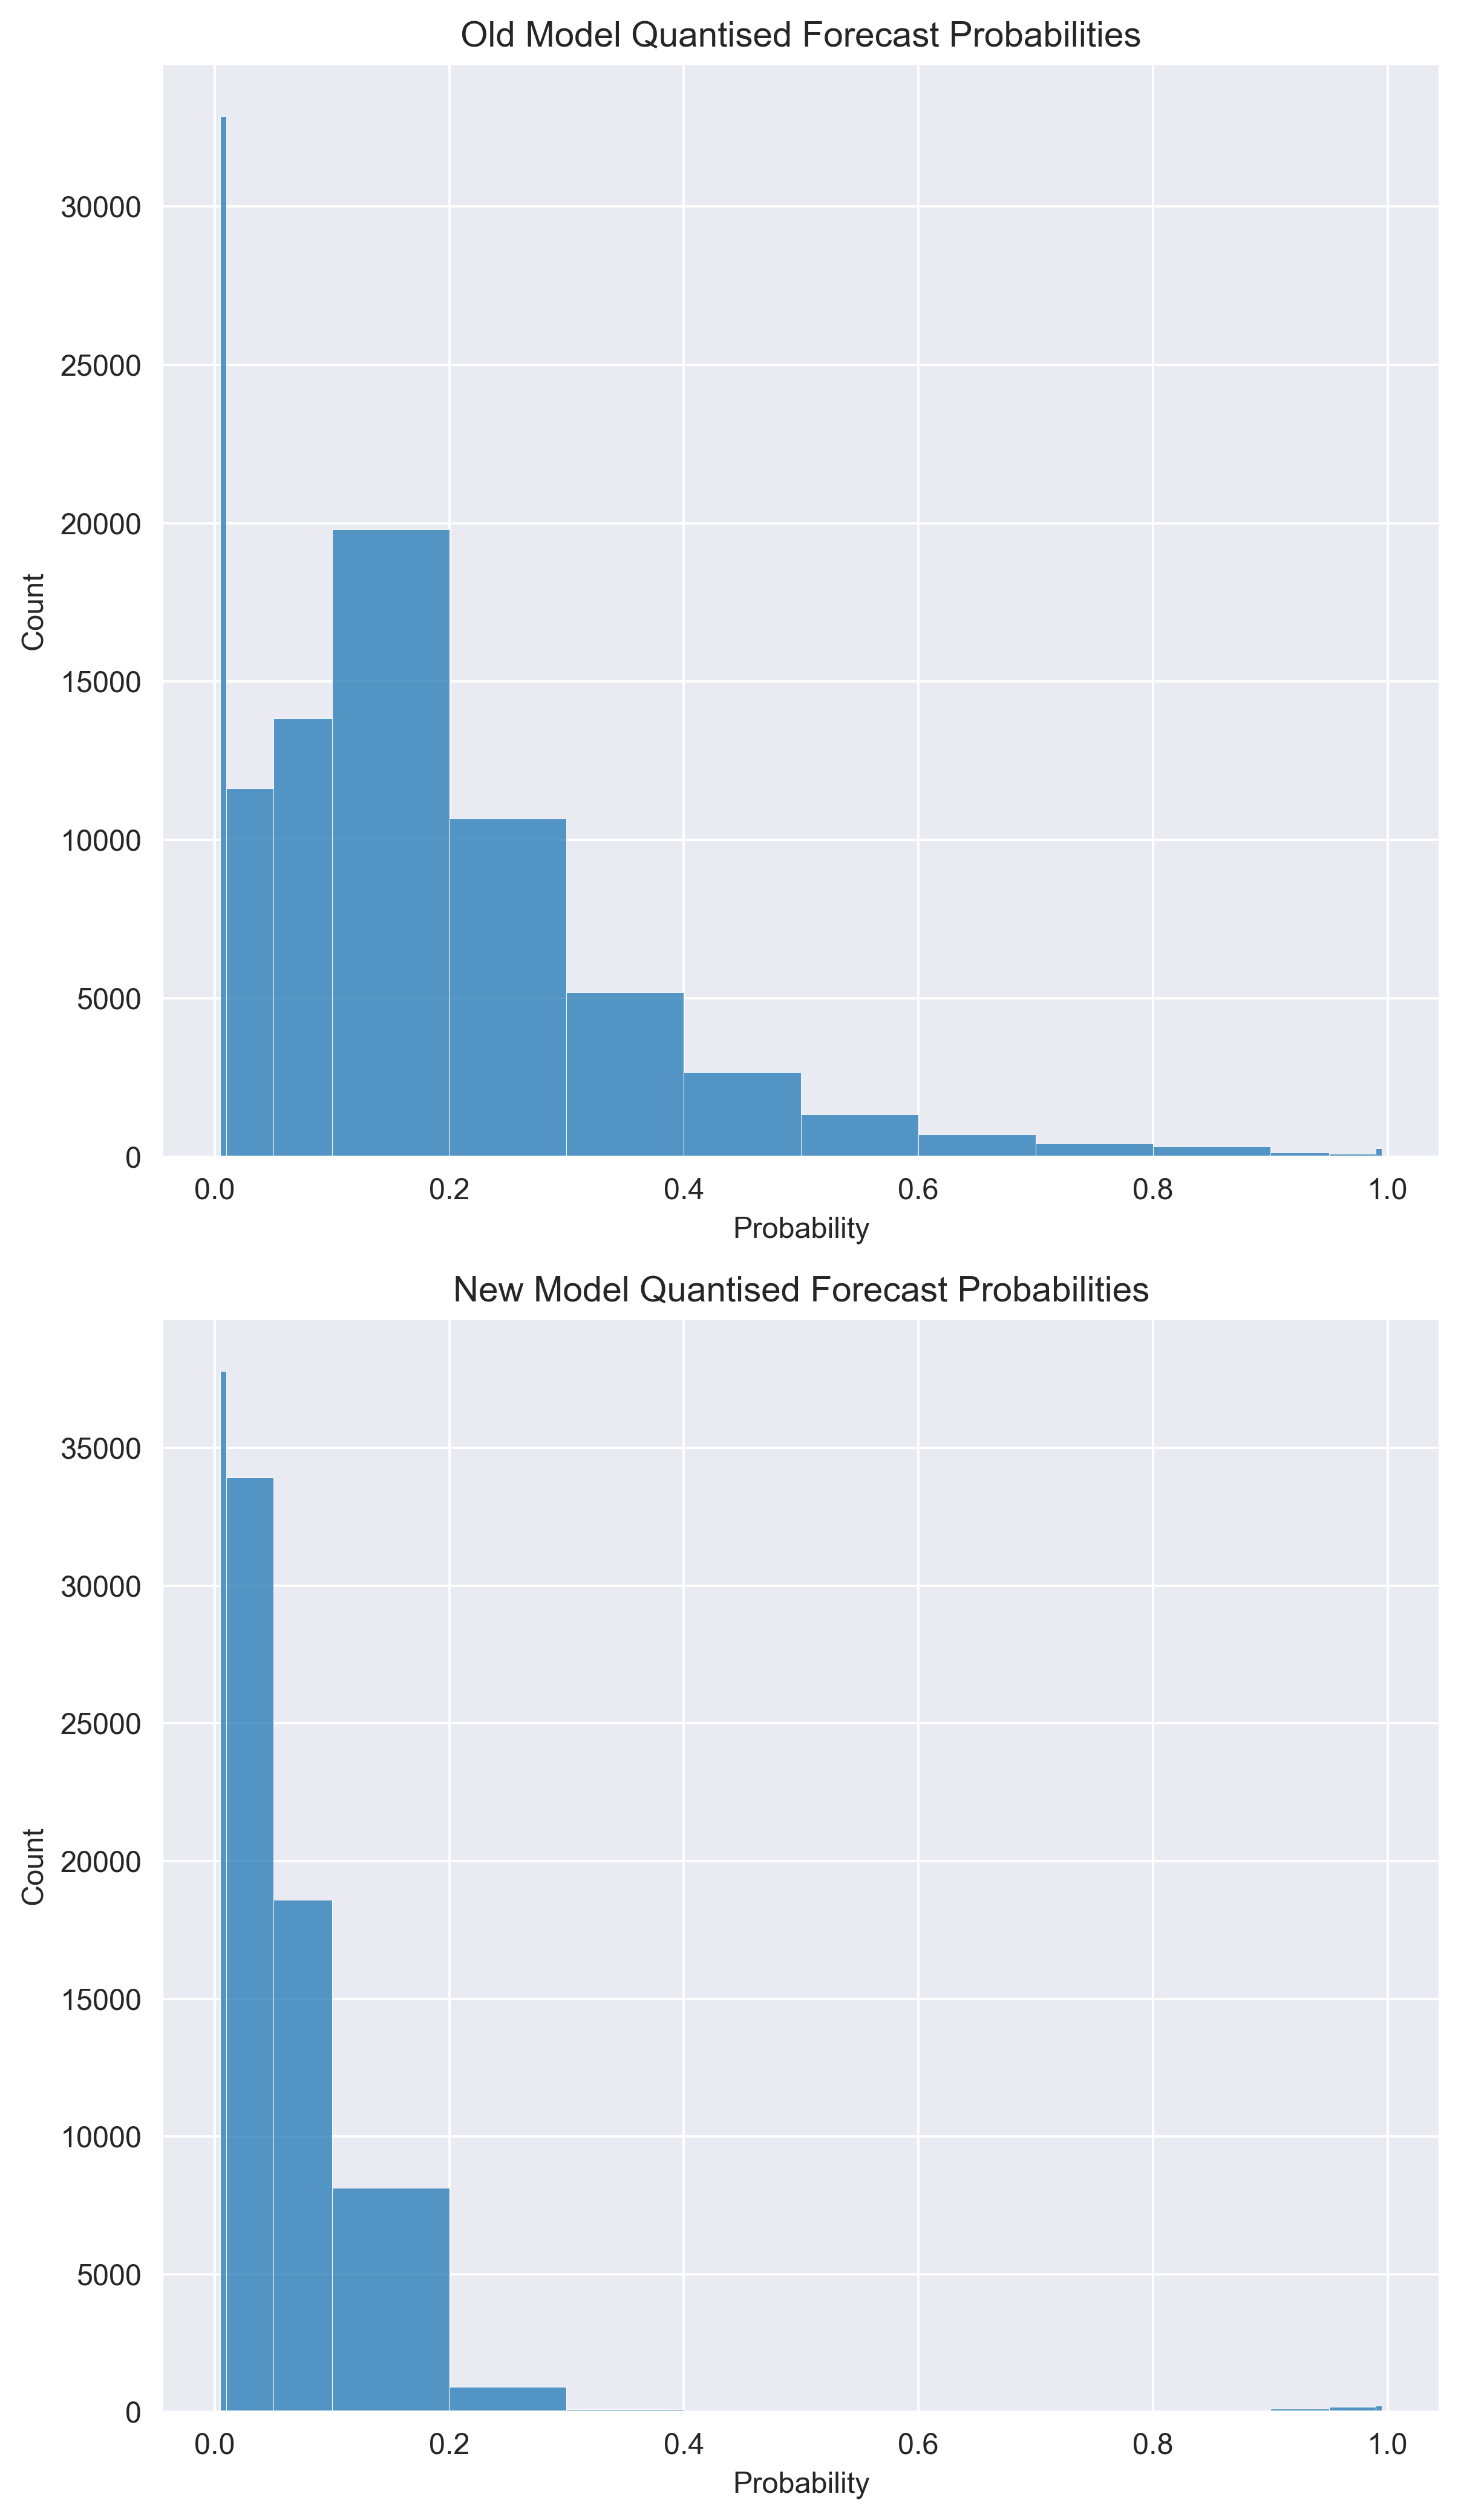

In [54]:
# Set up the figure with two subplots (two rows, one column)
fig, axs = plt.subplots(2, 1, figsize=(7, 12), dpi=350)

# Generate and plot the old quantised time series on the first subplot
df_old_raw, df_old = generate_and_quantise_time_series(N, base_rate, error_old_f, autocorr, p_k, ax=axs[0])
axs[0].set_title('Old Model Quantised Forecast Probabilities')

# Generate and plot the new quantised time series on the second subplot
df_new_raw, df_new = generate_and_quantise_time_series(N, base_rate, error_new_f, autocorr, p_k, o=df_old['o'], ax=axs[1])
axs[1].set_title('New Model Quantised Forecast Probabilities')

plt.tight_layout()  # Adjust the padding between and around the subplots
plt.show()

In [55]:
# Create a dataframe with p_k index and the number of forecasts that fall into each bin for the df_old_raw dataframe
_df = df_old_raw['f'].value_counts(bins=p_k, sort=False)
_df

f
(0.004, 0.01]    31430
(0.01, 0.05]     11639
(0.05, 0.1]      13837
(0.1, 0.2]       19810
(0.2, 0.3]       10680
(0.3, 0.4]        5200
(0.4, 0.5]        2684
(0.5, 0.6]        1342
(0.6, 0.7]         714
(0.7, 0.8]         421
(0.8, 0.9]         323
(0.9, 0.95]        135
(0.95, 0.99]       101
(0.99, 0.995]      268
Name: count, dtype: int64

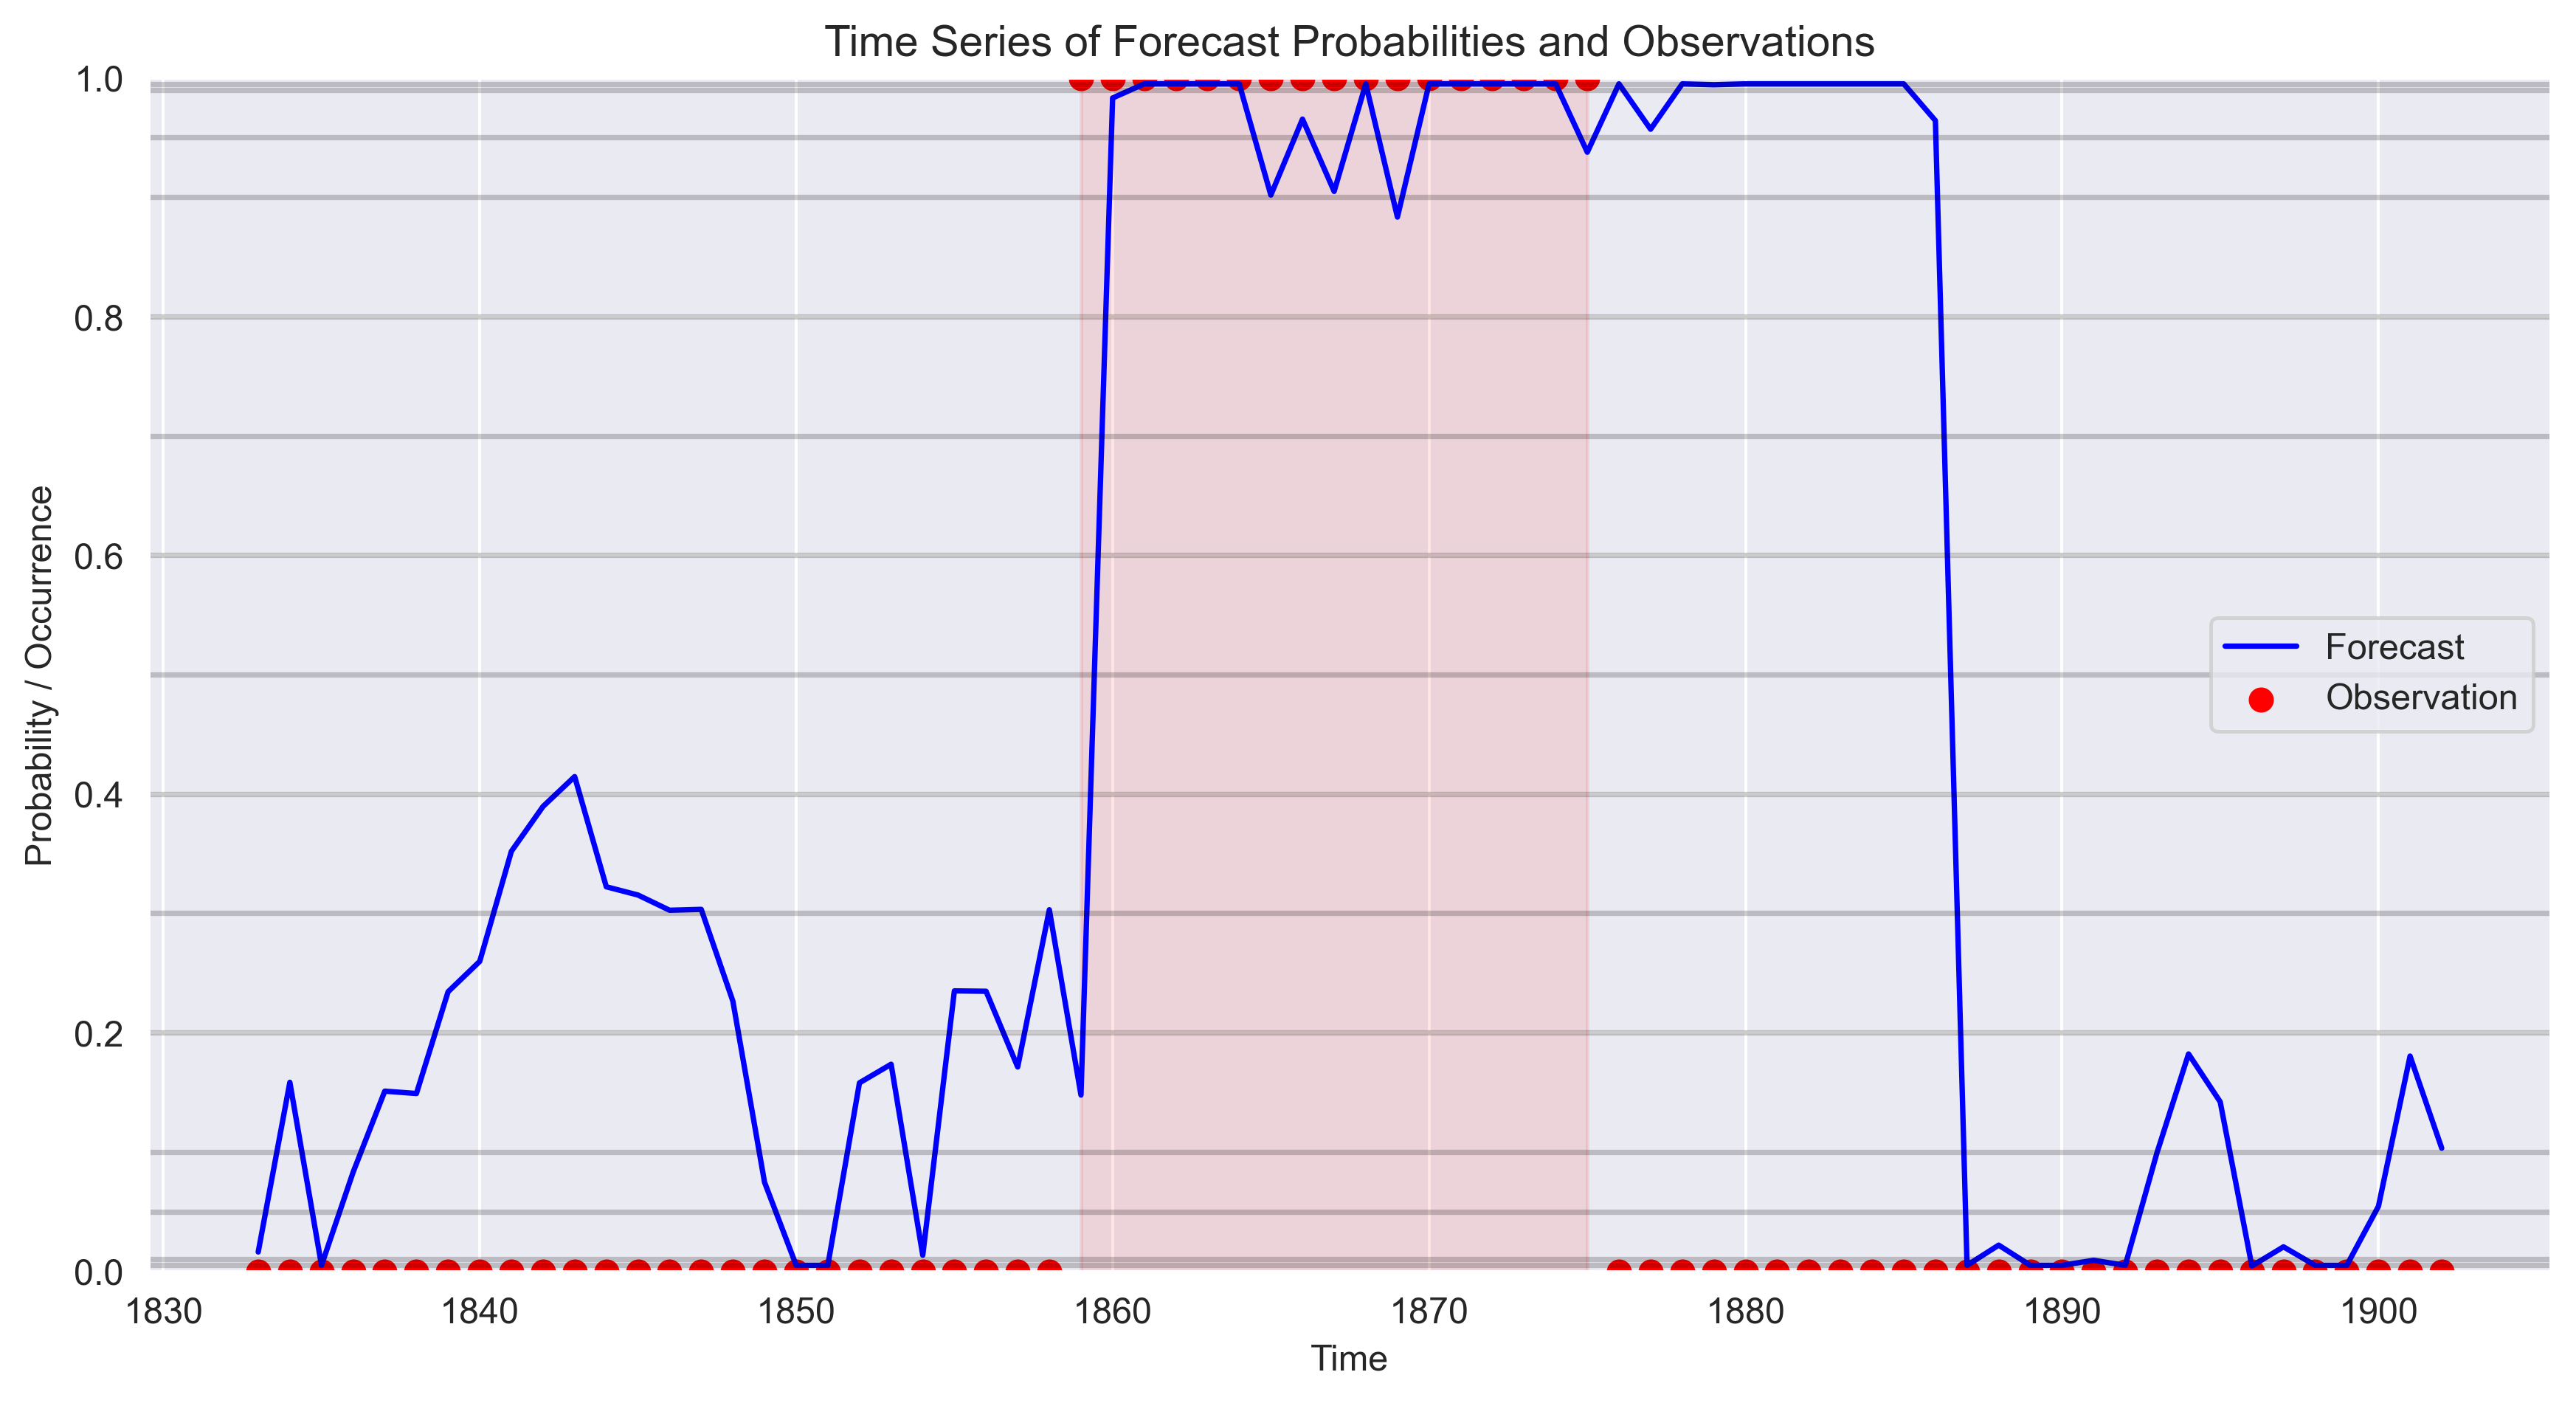

In [56]:
plot_time_series(df_old_raw,"f", nn)

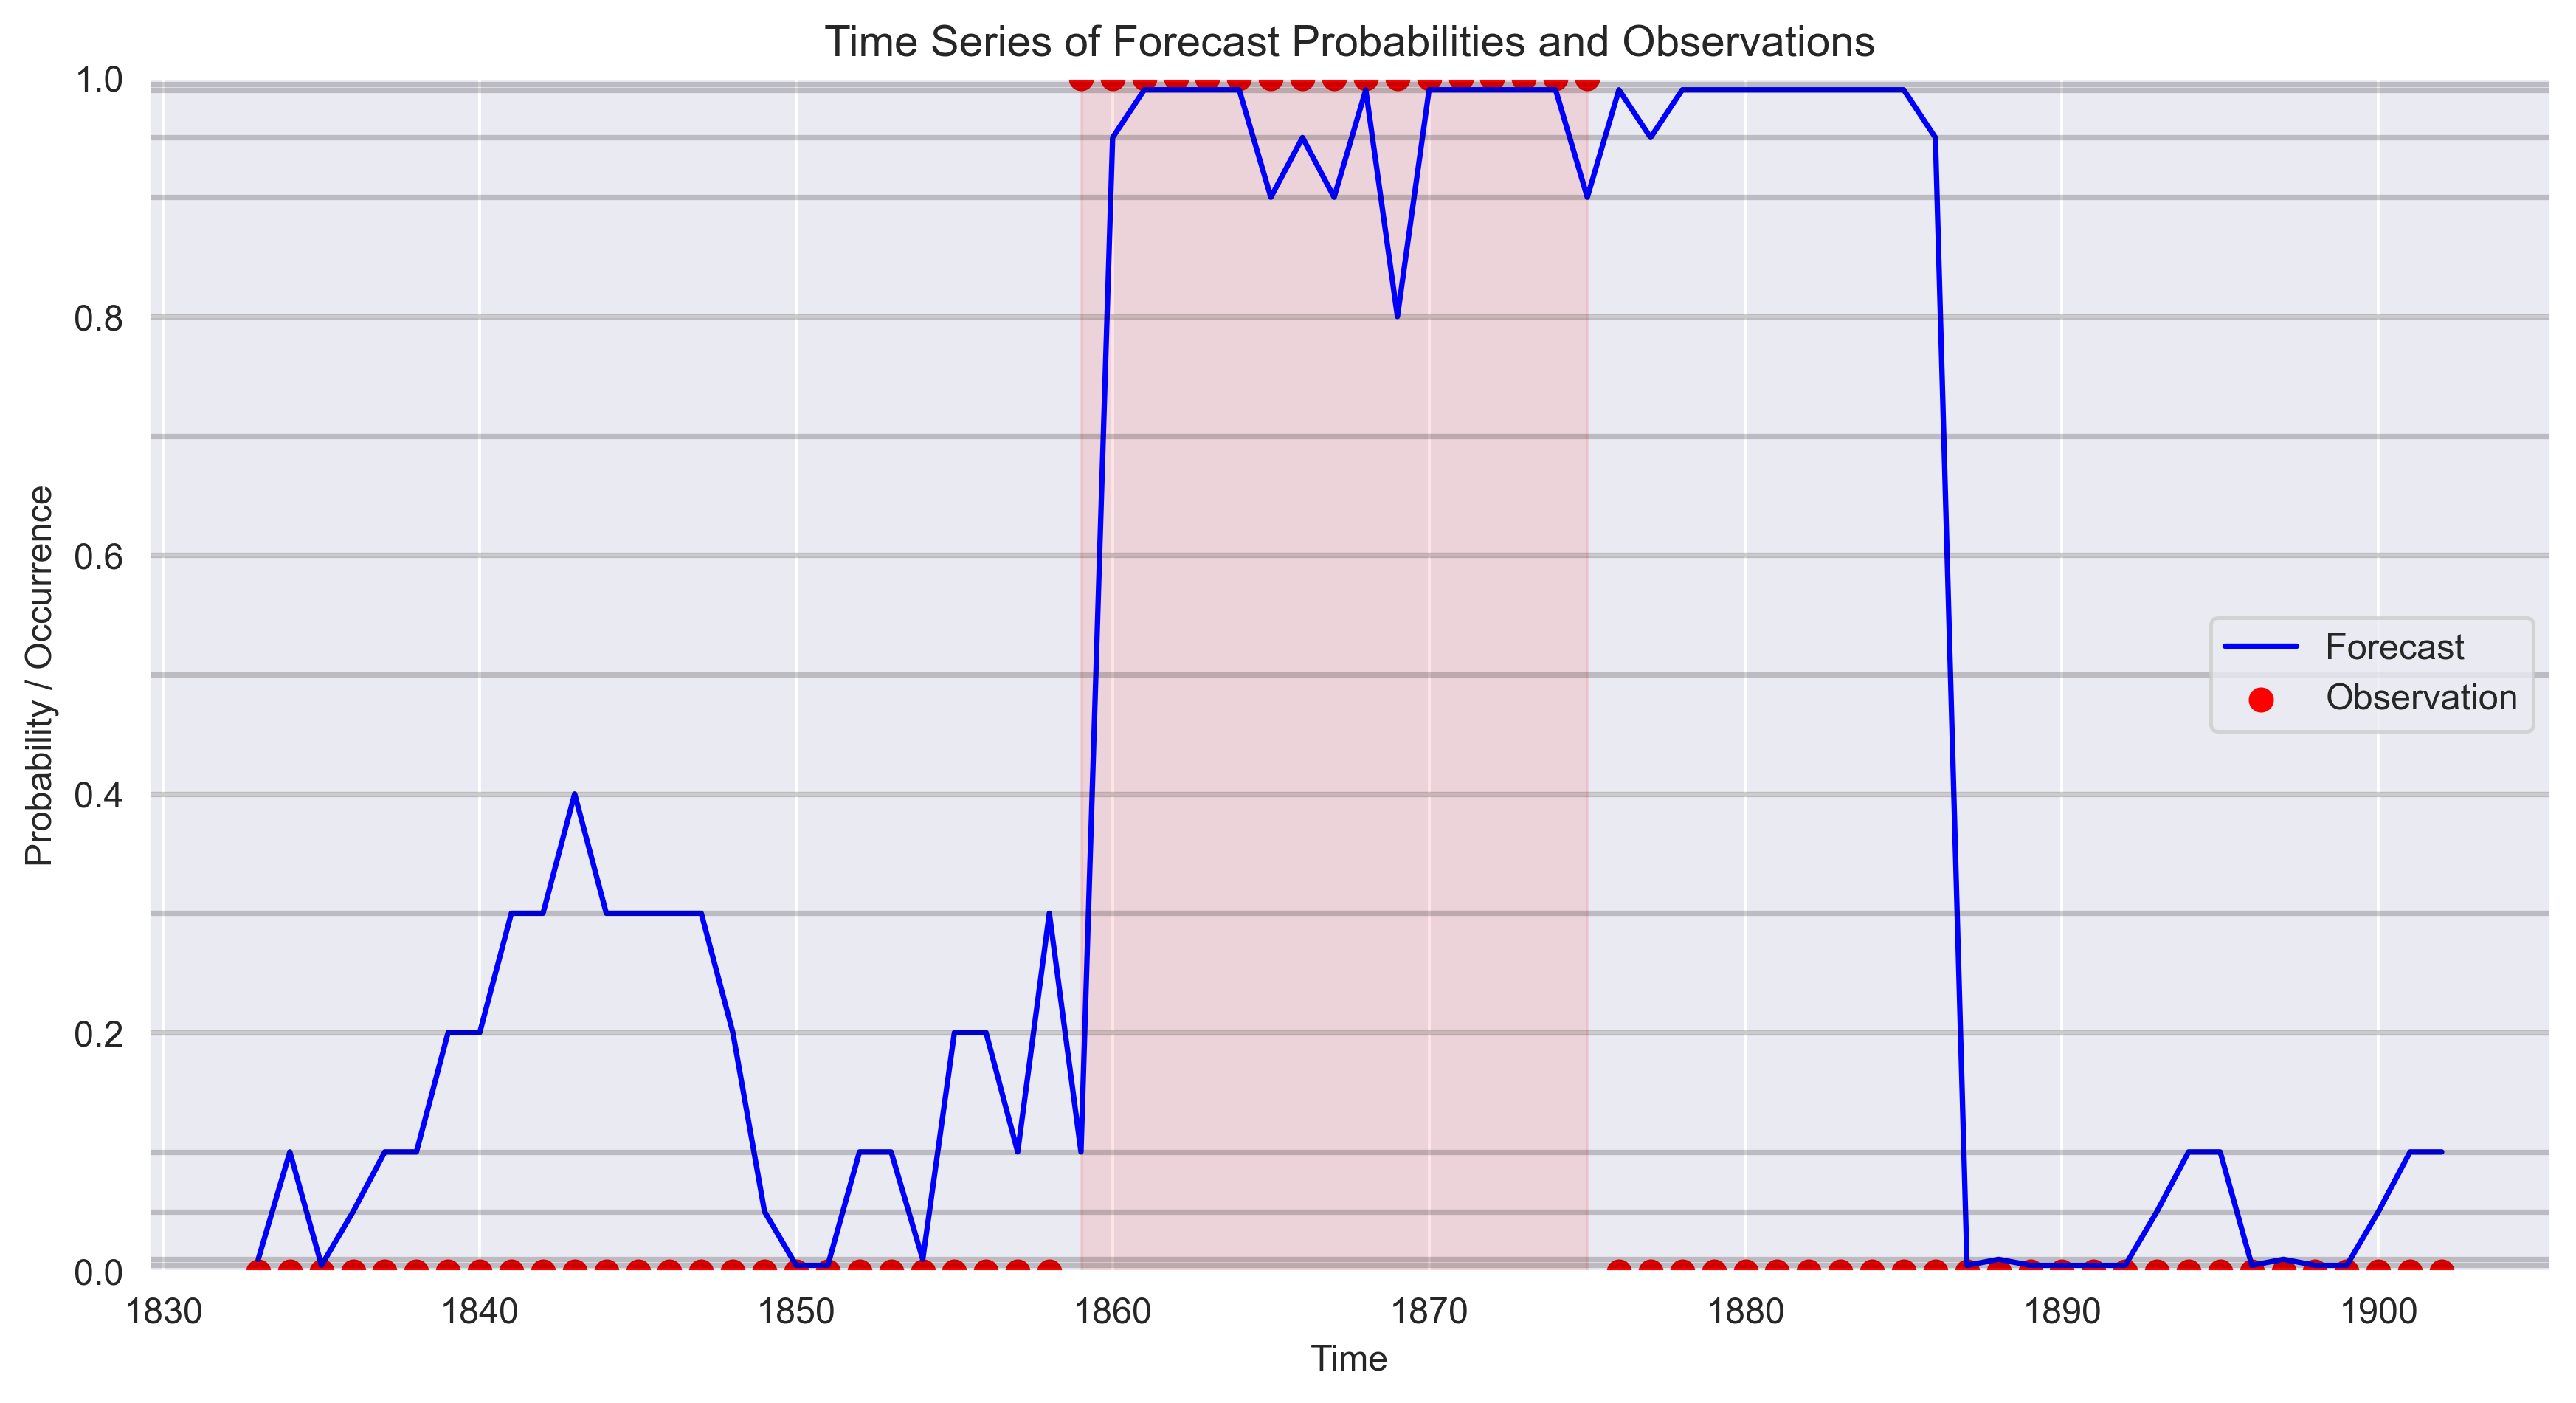

In [57]:
plot_time_series(df_old,"f_quantised",nn)

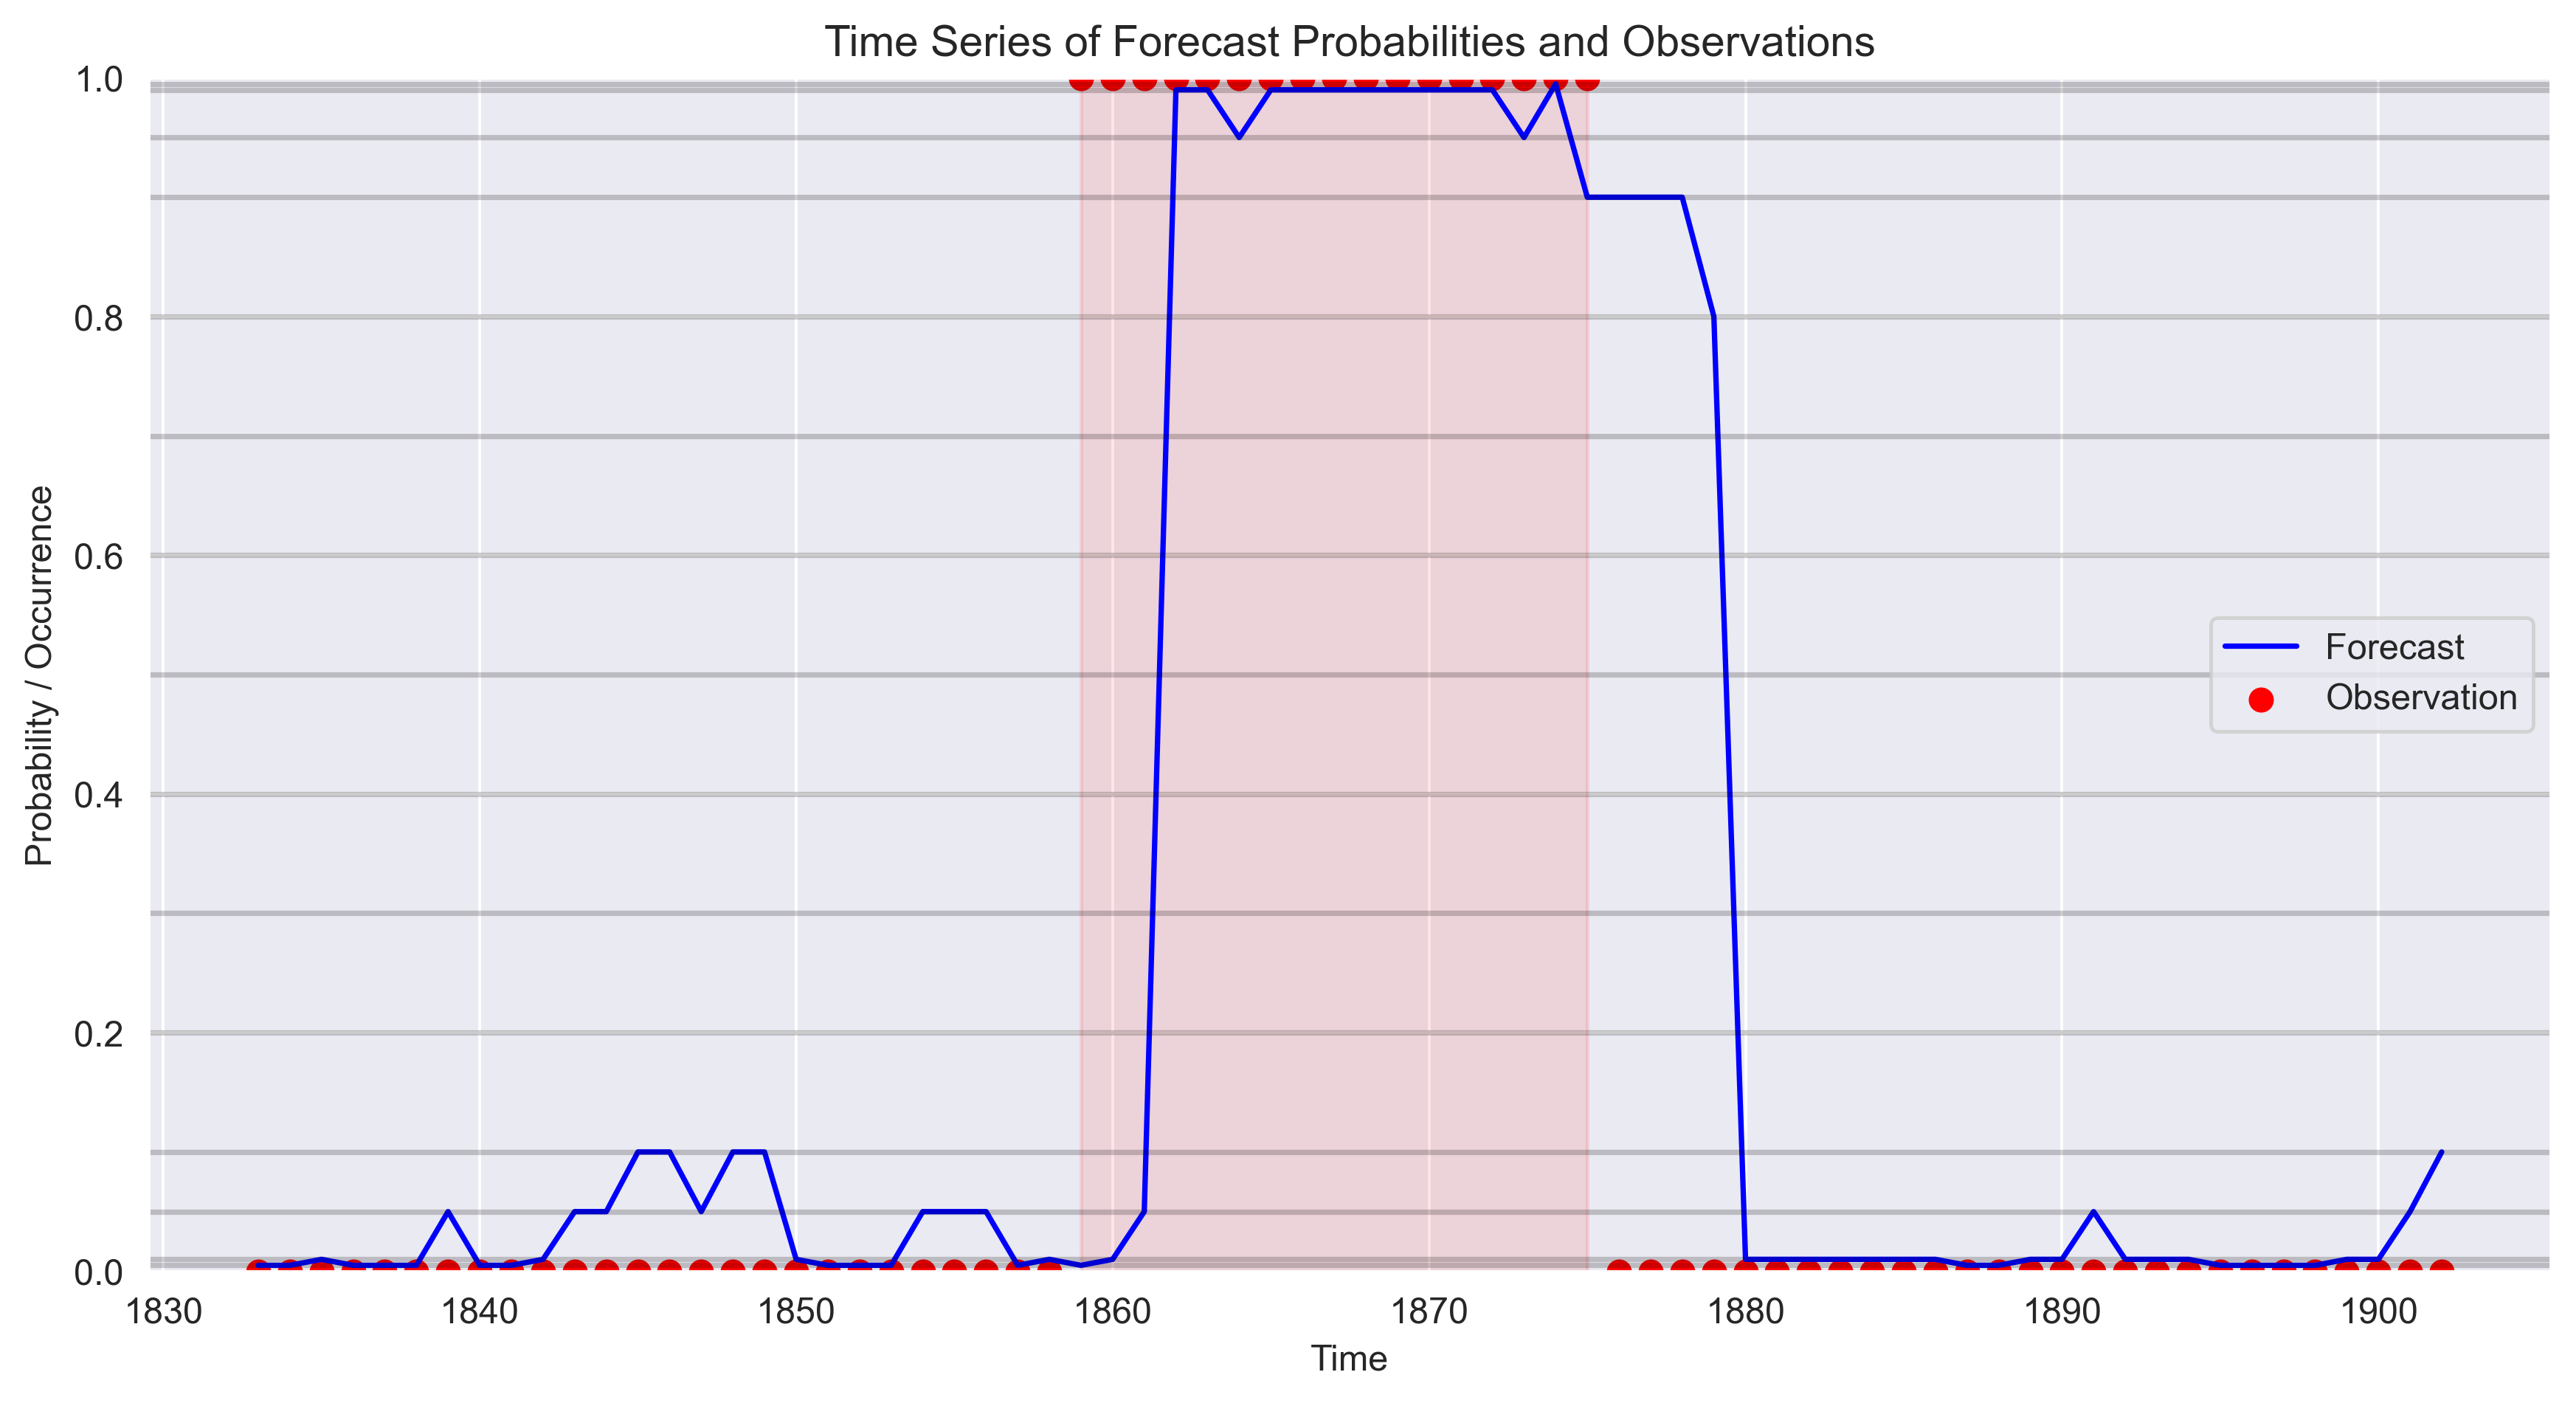

In [58]:
plot_time_series(df_new,"f_quantised",nn)


In [59]:
# Use the staticmethod compute_dkl to compute the DKL for the same forecast and observation period shown above
# This is the DKL for the old model
# plot_time_series_around_first_event(df_old, 'f_quantised', nn, score='dkl')


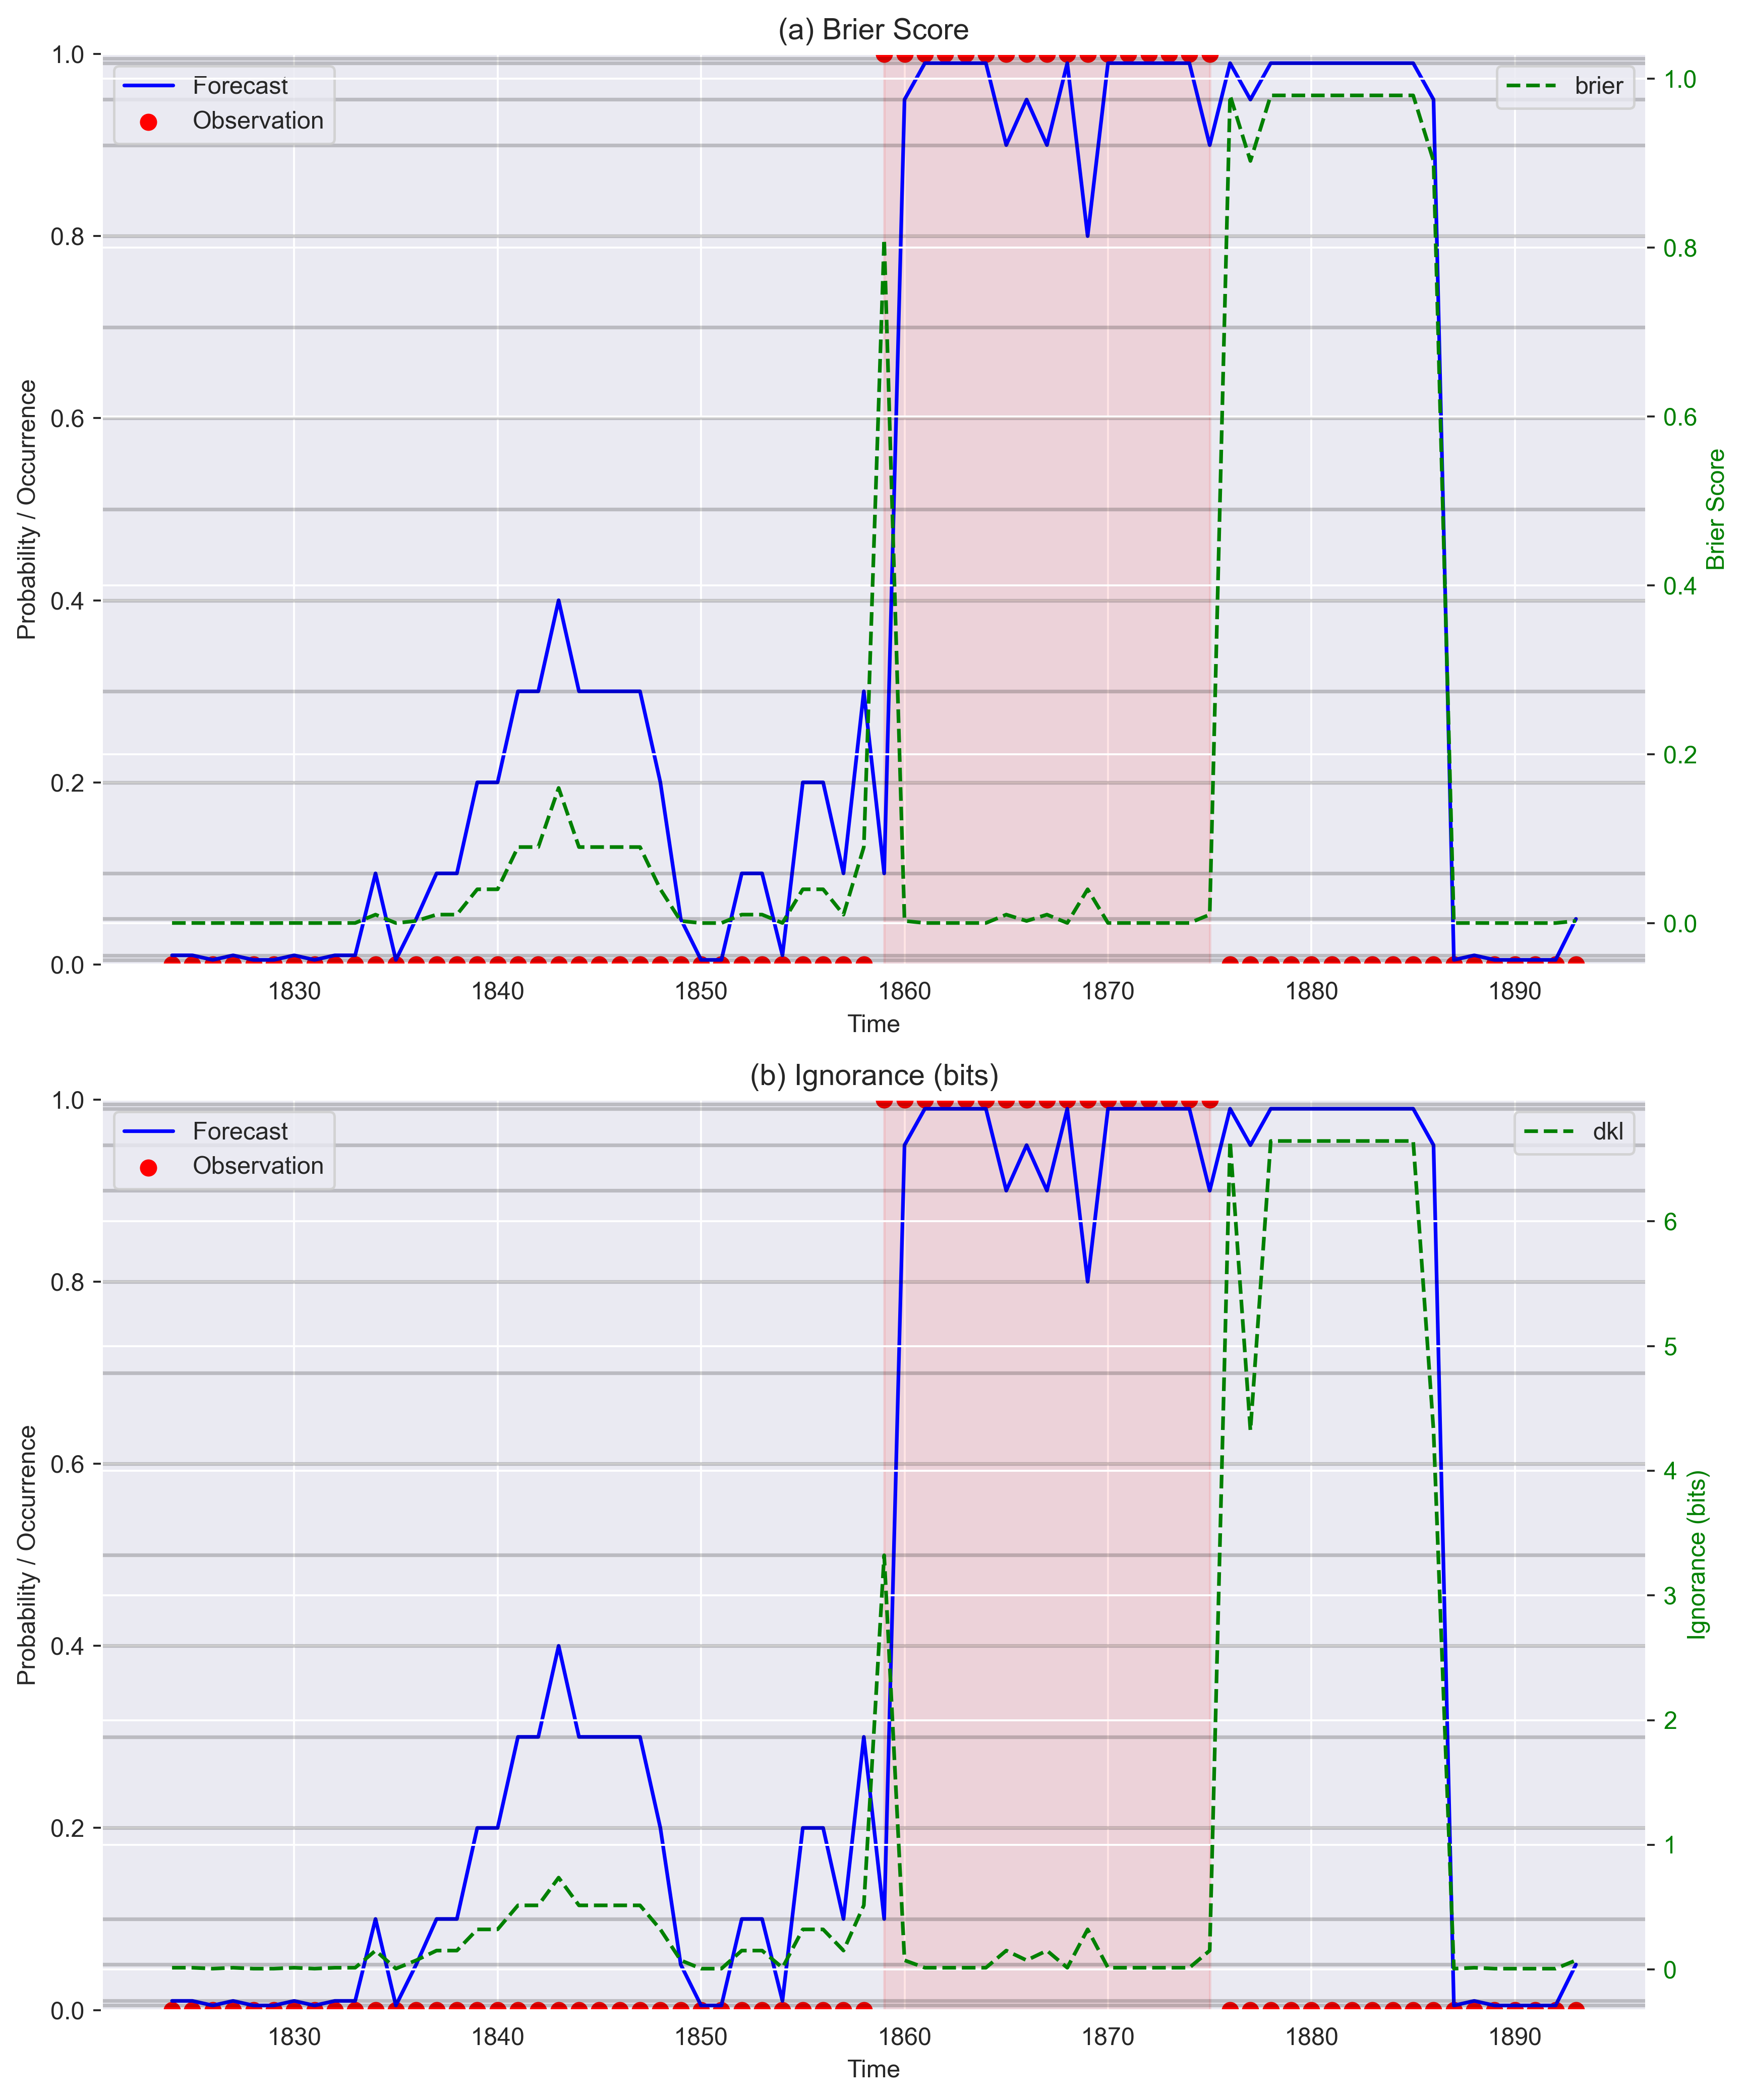

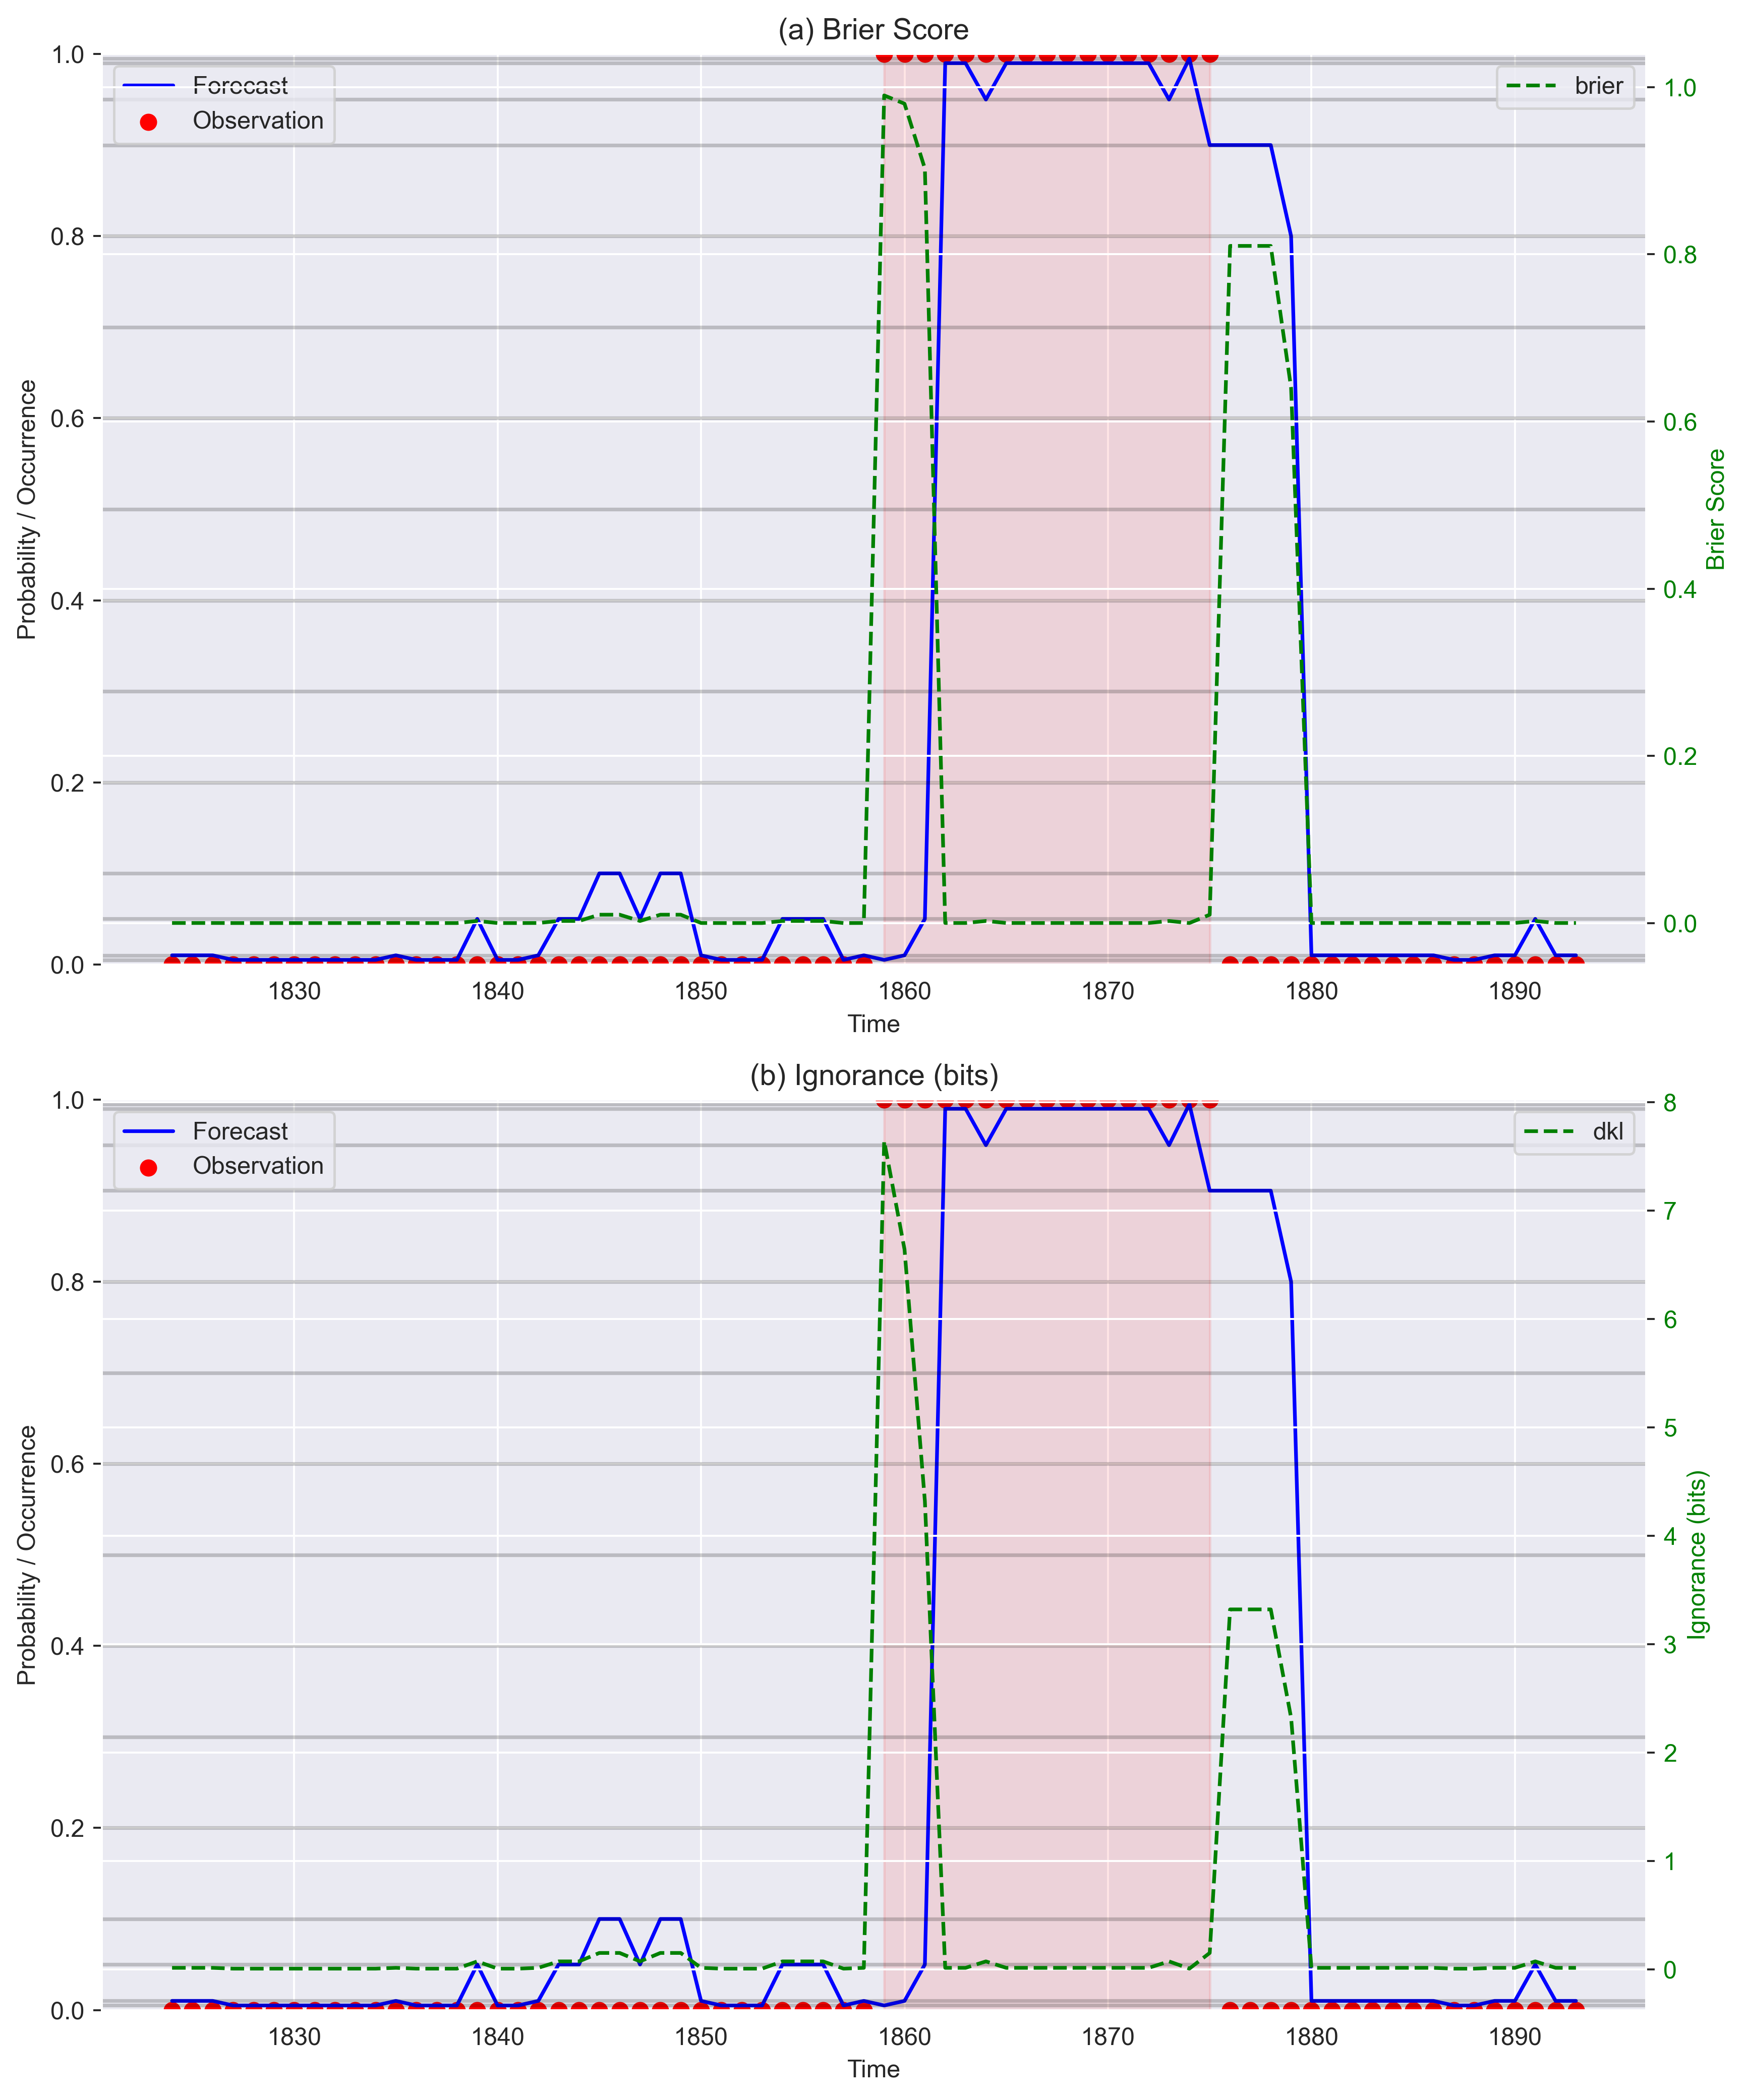

In [78]:
# Create a 2-panel plot for df_old with score set to 'brier' and 'dkl'
plot_time_series_multi_scores(df_old, 'f_quantised', nn, ['brier', 'dkl'])

# Create a 2-panel plot for df_new with score 'brier' and 'dkl'
plot_time_series_multi_scores(df_new, 'f_quantised', nn, ['brier', 'dkl'])

In [61]:
# Check pre-quantisised forecast probabilities for sanity
ig_old_raw = DKL(df_old['f'], df_old['o'], binning_k=p_k)
ig_old_raw.df 

,k,p_k,o_k,n_k
0,0,0.005,101.0,32091.0
1,1,0.010,16.0,6599.0
2,2,0.050,40.0,13038.0
3,3,0.100,47.0,18034.0
4,4,0.200,35.0,14727.0
5,5,0.300,34.0,7391.0
6,6,0.400,13.0,3690.0
7,7,0.500,12.0,1869.0
8,8,0.600,8.0,971.0
9,9,0.700,12.0,564.0


In [62]:
# Now compute information gain of the new system over the old 
ig_old = DKL(df_old['f_quantised'], df_old['o'], binning_k=p_k)
ig_new = DKL(df_new['f_quantised'], df_new['o'], binning_k=p_k)


In [63]:
ig_old.df

,k,p_k,o_k,n_k
0,0,0.005,103.0,32835.0
1,1,0.010,30.0,11639.0
2,2,0.050,39.0,13837.0
3,3,0.100,49.0,19810.0
4,4,0.200,34.0,10680.0
5,5,0.300,27.0,5200.0
6,6,0.400,10.0,2684.0
7,7,0.500,11.0,1342.0
8,8,0.600,5.0,714.0
9,9,0.700,21.0,421.0


In [64]:
ig_new.df

,k,p_k,o_k,n_k
0,0,0.005,107.0,37803.0
1,1,0.010,99.0,33930.0
2,2,0.050,67.0,18596.0
3,3,0.100,41.0,8139.0
4,4,0.200,2.0,900.0
5,5,0.300,0.0,86.0
6,6,0.400,0.0,11.0
7,7,0.500,0.0,0.0
8,8,0.600,1.0,1.0
9,9,0.700,5.0,5.0


In [65]:
ig_old.ign_from_components(prints=True)


,Reliability,Resolution,Uncertainty,Ignorance,Ignorance Skill Score
0,0.156704,0.010957,0.048522,0.19427,-3.003748


In [66]:
ig_new.ign_from_components(prints=True)

,Reliability,Resolution,Uncertainty,Ignorance,Ignorance Skill Score
0,0.035295,0.012776,0.048522,0.071041,-0.464104


In [67]:
df_old_stats = ig_old.compute_components(prints=True)
df_old_stats

,Reliability,Resolution,Uncertainty,Ignorance,Ignorance Skill Score,Brier Score,Brier Skill Score
0,0.156704,0.010957,0.048522,0.19427,-3.003748,0.030855,-4.734307


In [68]:
df_new_stats = ig_new.compute_components(prints=True)
df_new_stats

,Reliability,Resolution,Uncertainty,Ignorance,Ignorance Skill Score,Brier Score,Brier Skill Score
0,0.035295,0.012776,0.048522,0.071041,-0.464104,0.00752,-0.397509


In [69]:
### These are the statistics 
# Combine the two dataframes into one for comparison
df_stats = pd.concat([df_old_stats, df_new_stats], axis=0)
# set the index as a string for the model names, "old" and "new"
df_stats.index = ['Old', 'New']
df_stats

,Reliability,Resolution,Uncertainty,Ignorance,Ignorance Skill Score,Brier Score,Brier Skill Score
Old,0.156704,0.010957,0.048522,0.194270,-3.003748,0.030855,-4.734307
New,0.035295,0.012776,0.048522,0.071041,-0.464104,0.007520,-0.397509


In [70]:
### These are the forecast time series
f_old = df_old['f_quantised']
f_new = df_new['f_quantised']

In [71]:
#### These are the binned statistics from the dkl object for the old and new models 
df_old_binned = ig_old.df
df_new_binned = ig_new.df
df_old_binned

,k,p_k,o_k,n_k
0,0,0.005,103.0,32835.0
1,1,0.010,30.0,11639.0
2,2,0.050,39.0,13837.0
3,3,0.100,49.0,19810.0
4,4,0.200,34.0,10680.0
5,5,0.300,27.0,5200.0
6,6,0.400,10.0,2684.0
7,7,0.500,11.0,1342.0
8,8,0.600,5.0,714.0
9,9,0.700,21.0,421.0


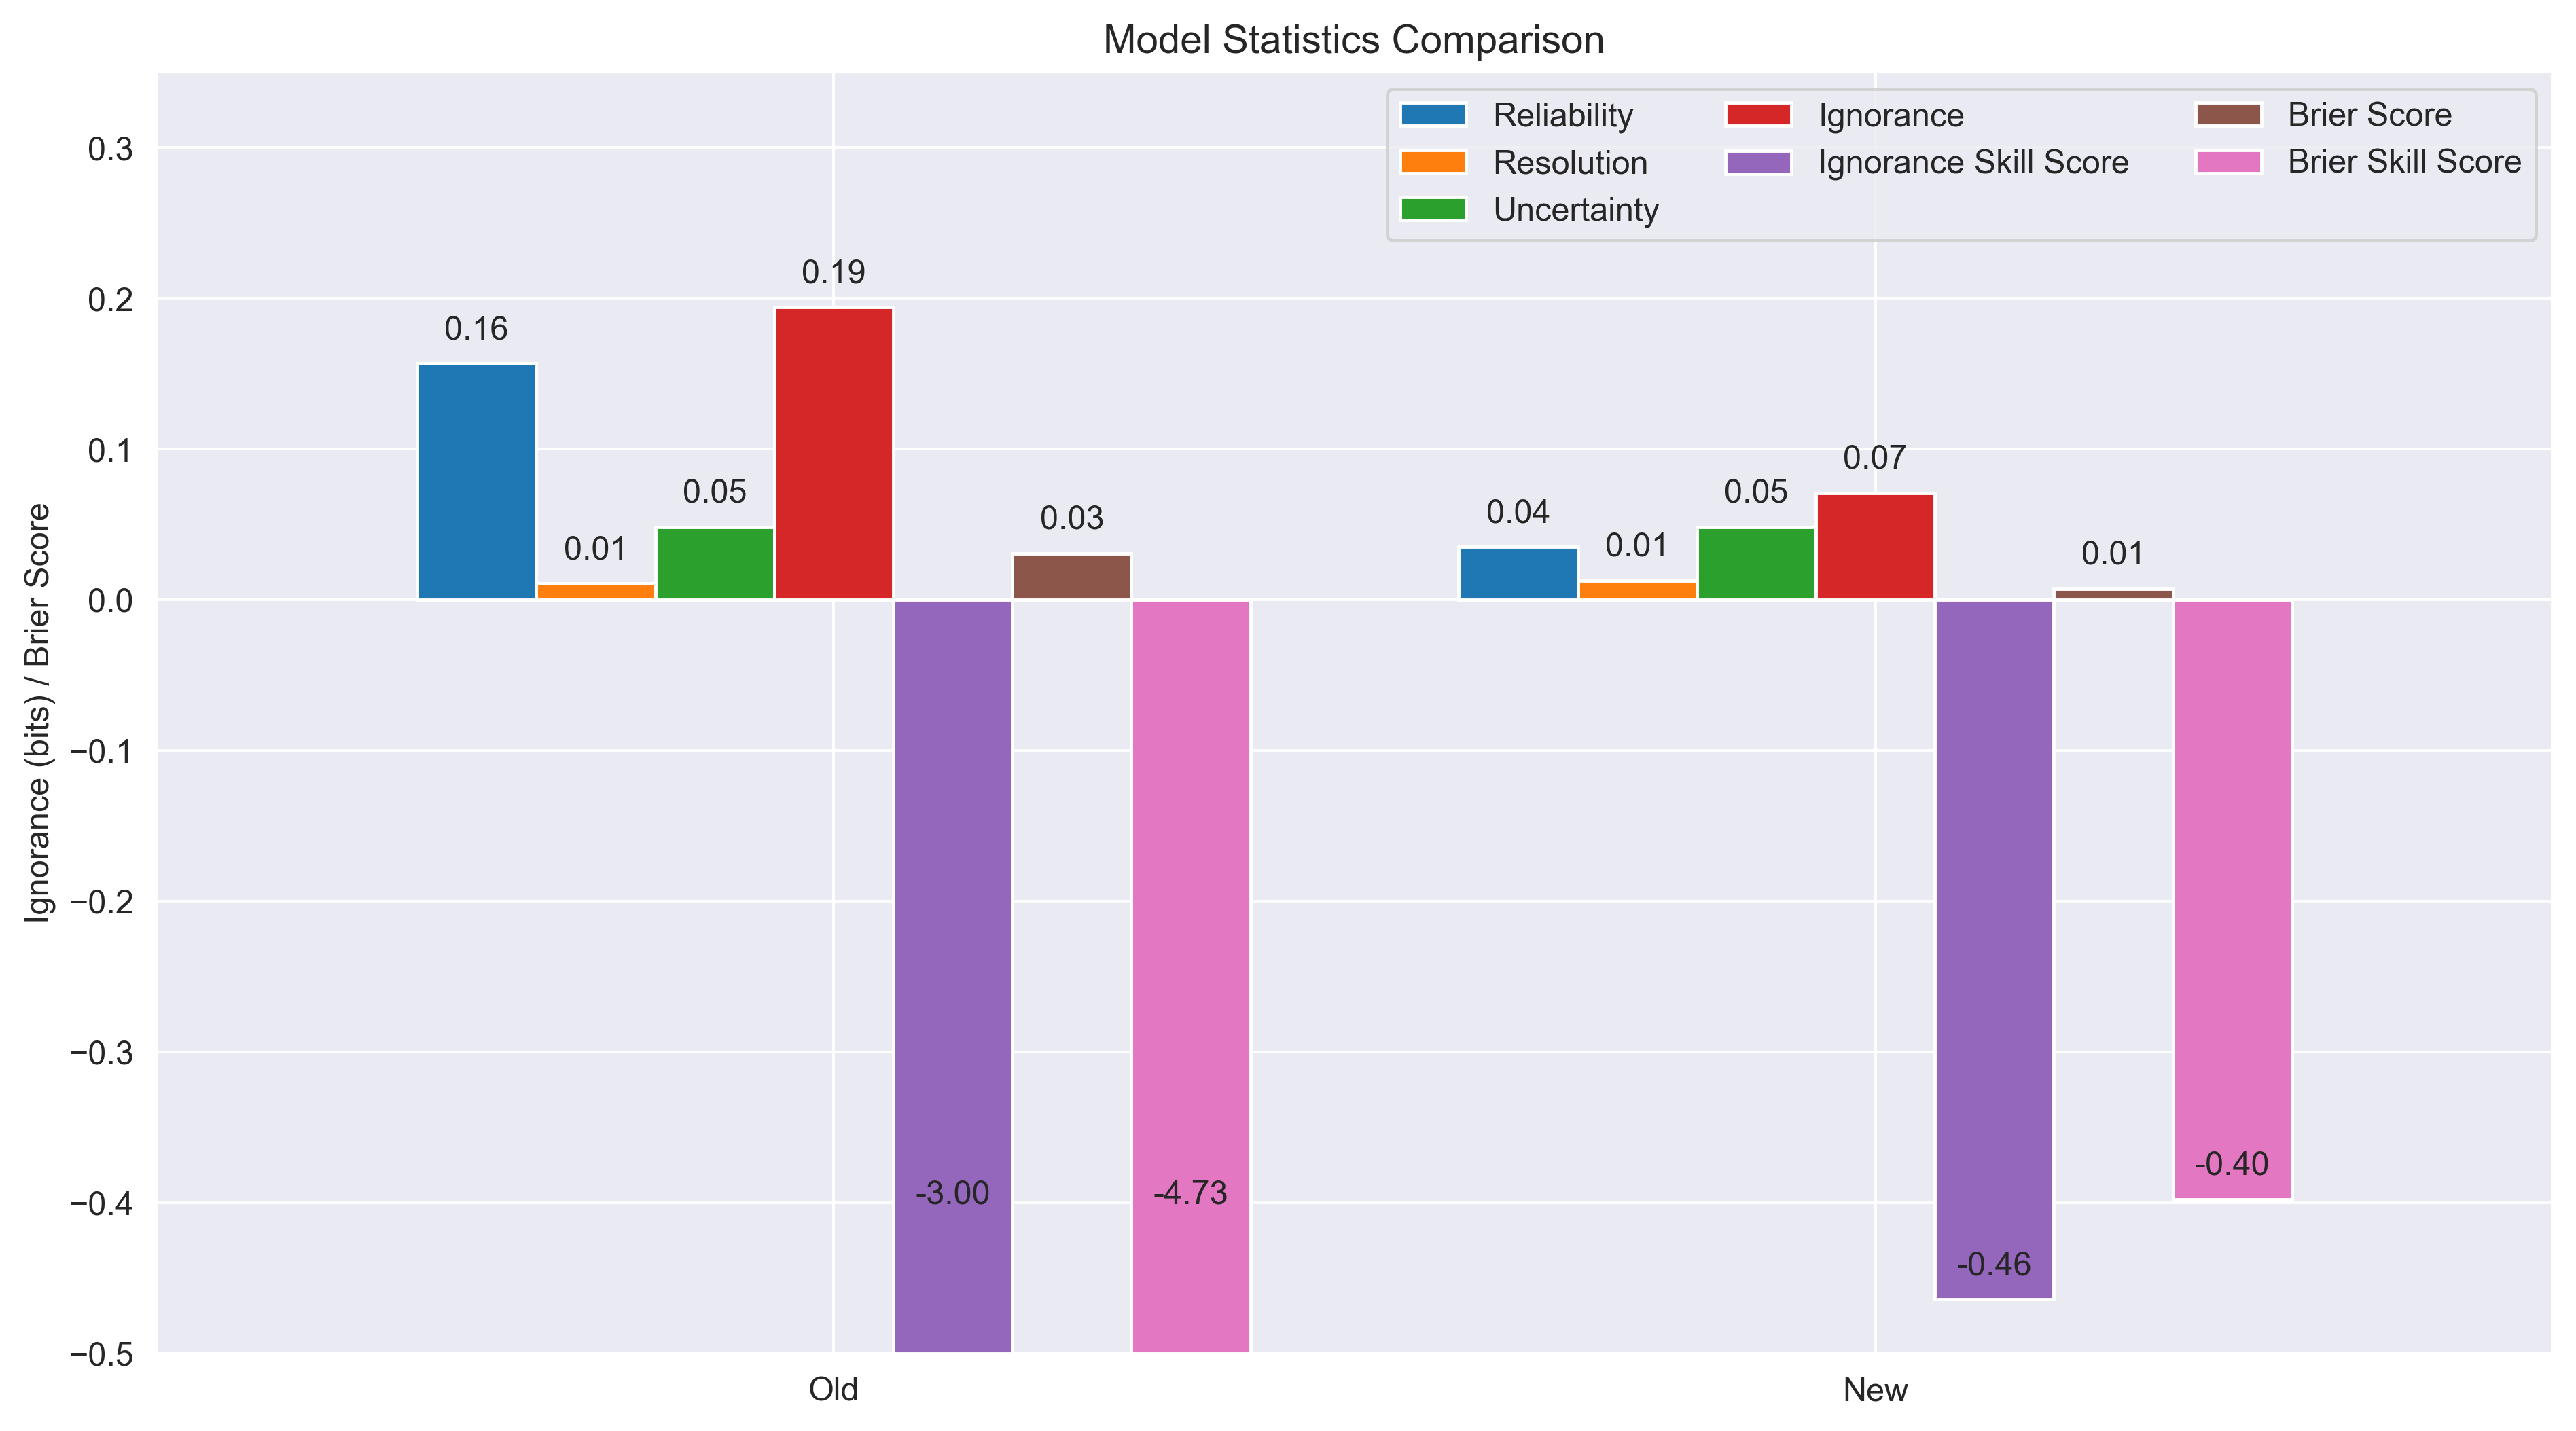

In [84]:
plot_model_stats_comparison(df_stats)

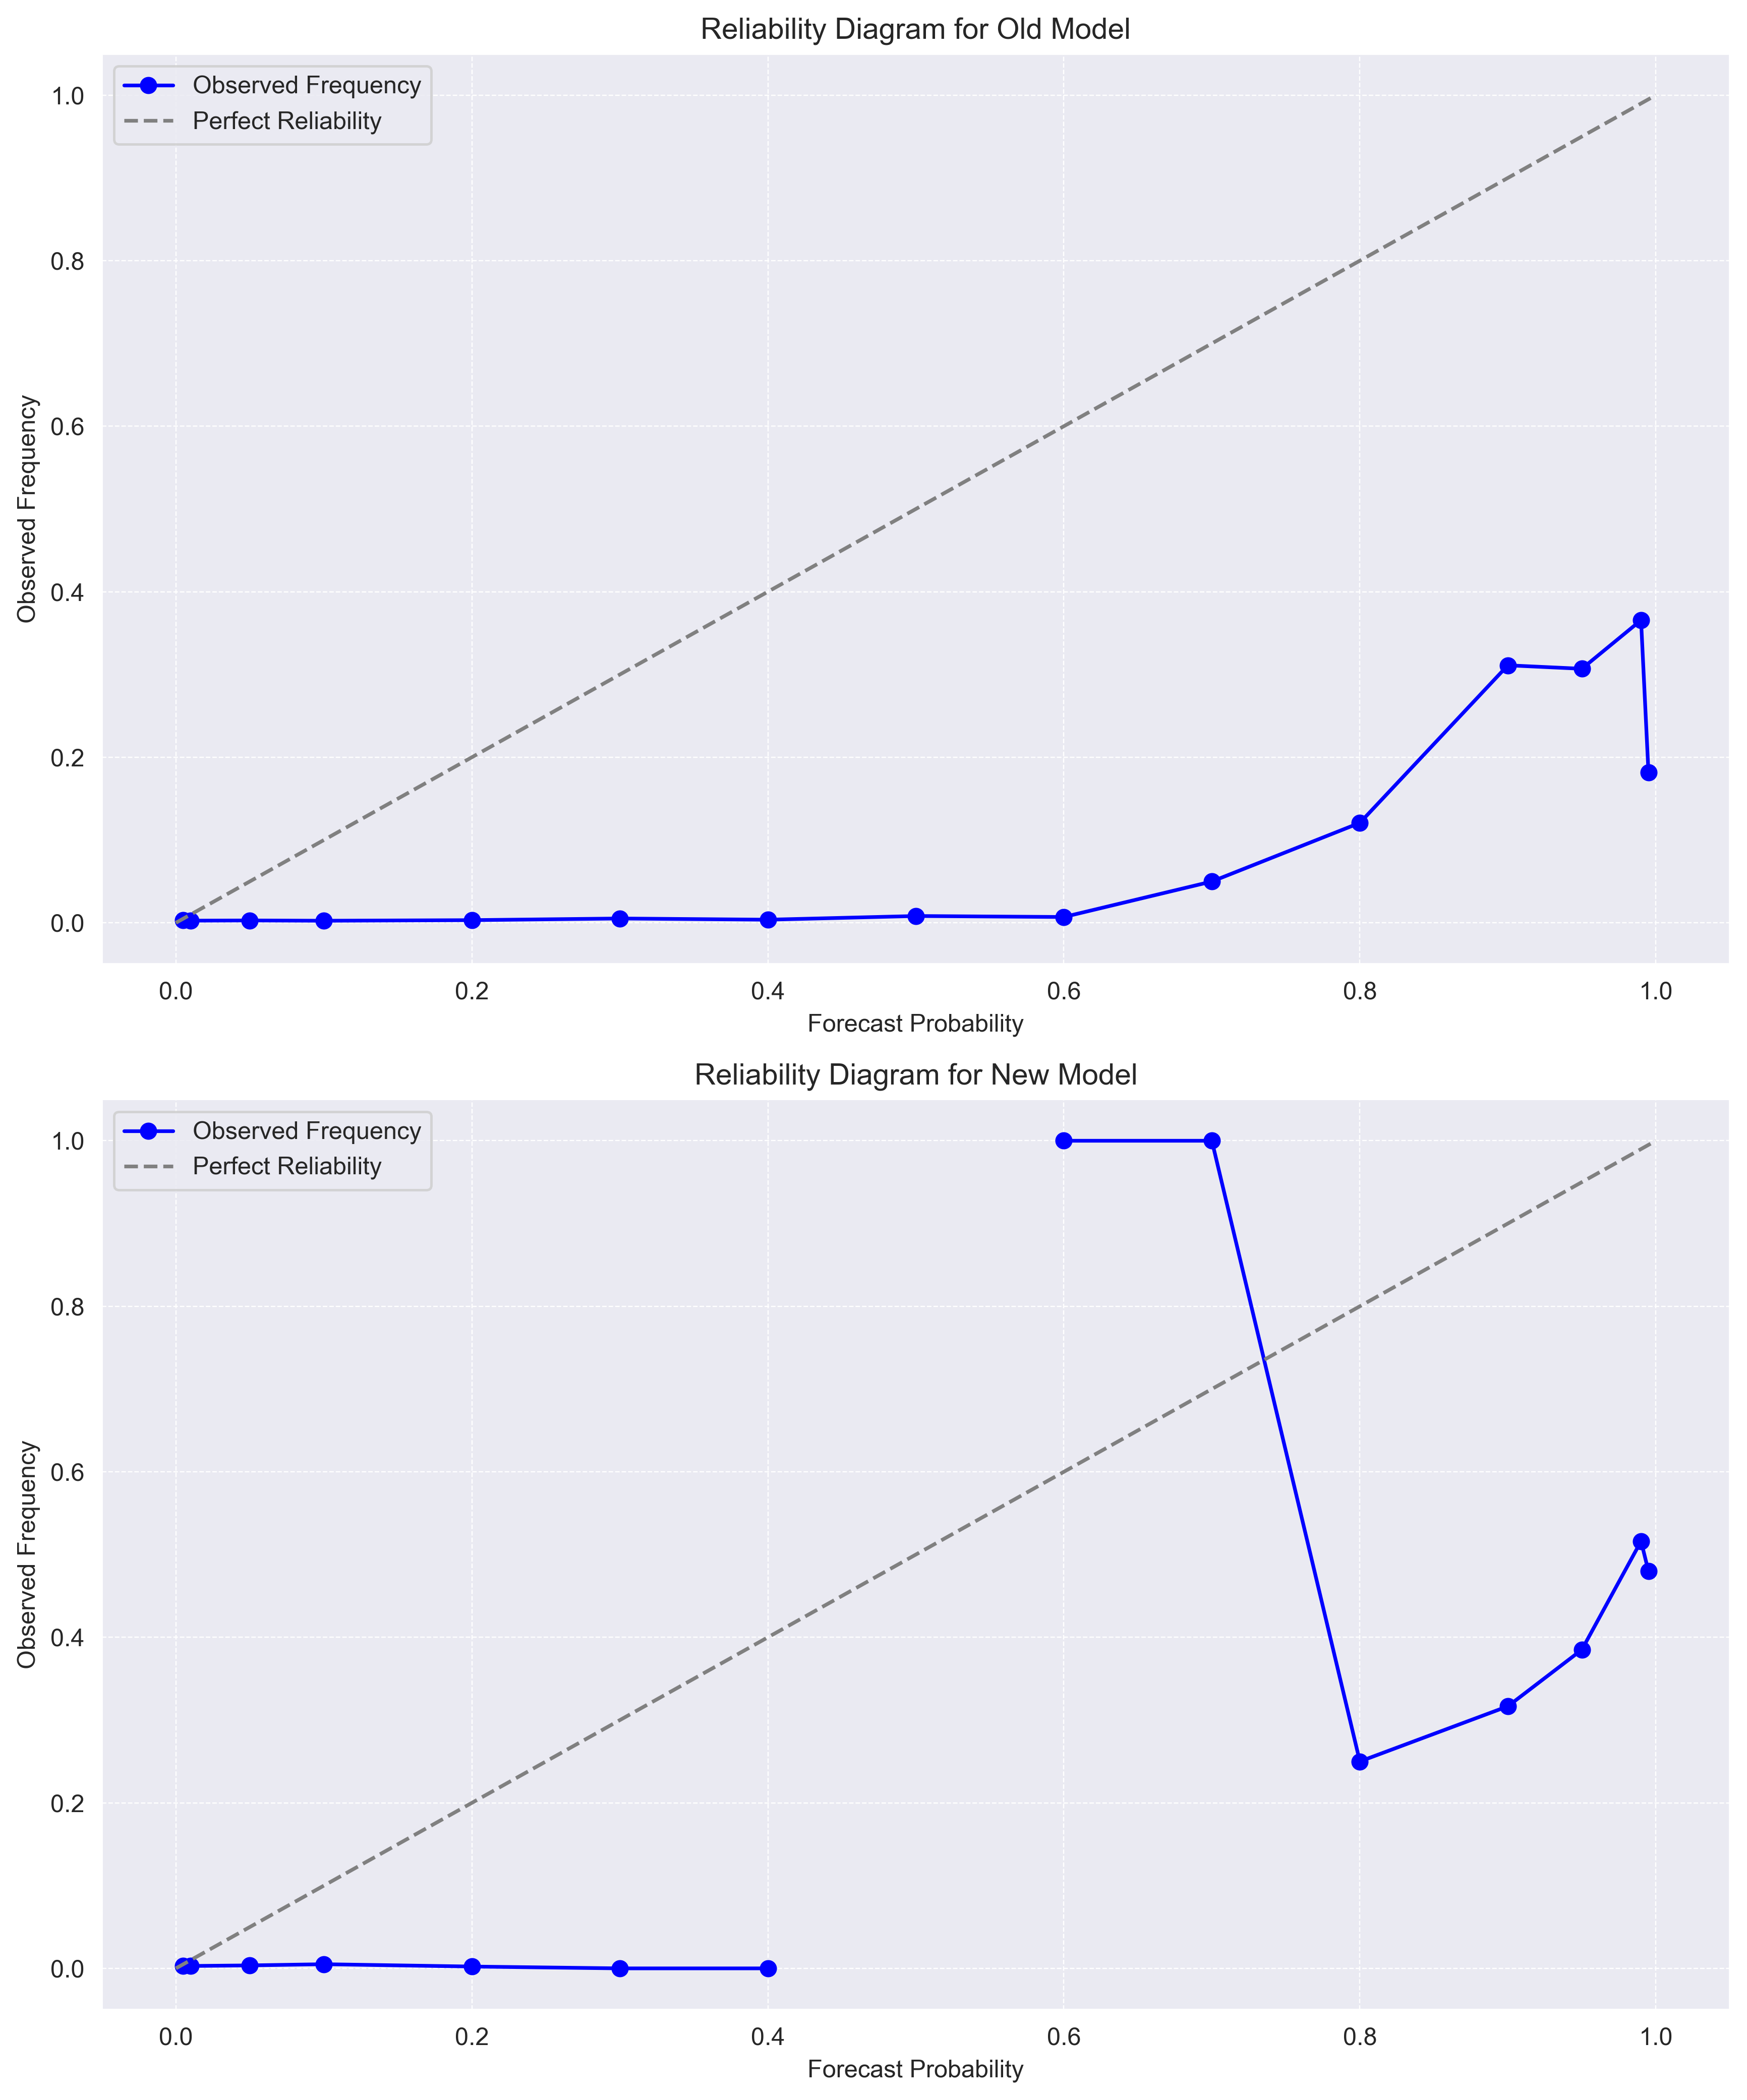

In [73]:
# plot_reliability(df_old_binned, title='Reliability Diagram for Old Model')
# plot_reliability(df_new_binned, title='Reliability Diagram for New Model')

# Create a figure with two subplots (two rows, one column)
fig, axs = plt.subplots(2, 1, figsize=(10, 12), dpi=350)

# Plot the reliability diagrams on the subplots
plot_reliability(df_old_binned, title='Reliability Diagram for Old Model', ax=axs[0])
plot_reliability(df_new_binned, title='Reliability Diagram for New Model', ax=axs[1])

# Adjust the padding between and around the subplots
plt.tight_layout()

# Save the figure as a PNG file
# plt.savefig('my_figure.png')
plt.show()

## Thoughts
We can see 
* The better the model does, the harder it is to see the reliability diagram due to small sample size 
* The new model is better than the old model in terms of resolution and ignorance
* Reliability unchanged; it is resolution (discrimination or sharpness) that has improved and accounted for the information gained (ignorance reduced)
* Brier Score has reduced for the new model - this is surprising because it's obviously better, but maybe there's a bug?
* Brier Skill Score and IGN skill scores both become less negative - we see the issue of using climatology as the baseline to beat, because it's so small and therefore unwieldy. Better to formulate as a gain against a "higher bar" - (how?)

In [74]:
# Compute information gain of the new system over the old but using the observation and forecast time series
# Do it 'event-wise' so each value is the gain over the old 
# First compute DKL over the whole time series
dkl_old = DKL.compute_dkl(df_old['o'],df_old['f_quantised'])
dkl_new = DKL.compute_dkl(df_new['o'],df_new['f_quantised'])
ig = calculate_info_gain(dkl_old, dkl_new)
ig

array([ 0.        ,  0.007268  , -0.007268  , ...,  0.07800251,
        0.13750352,  0.06676901])

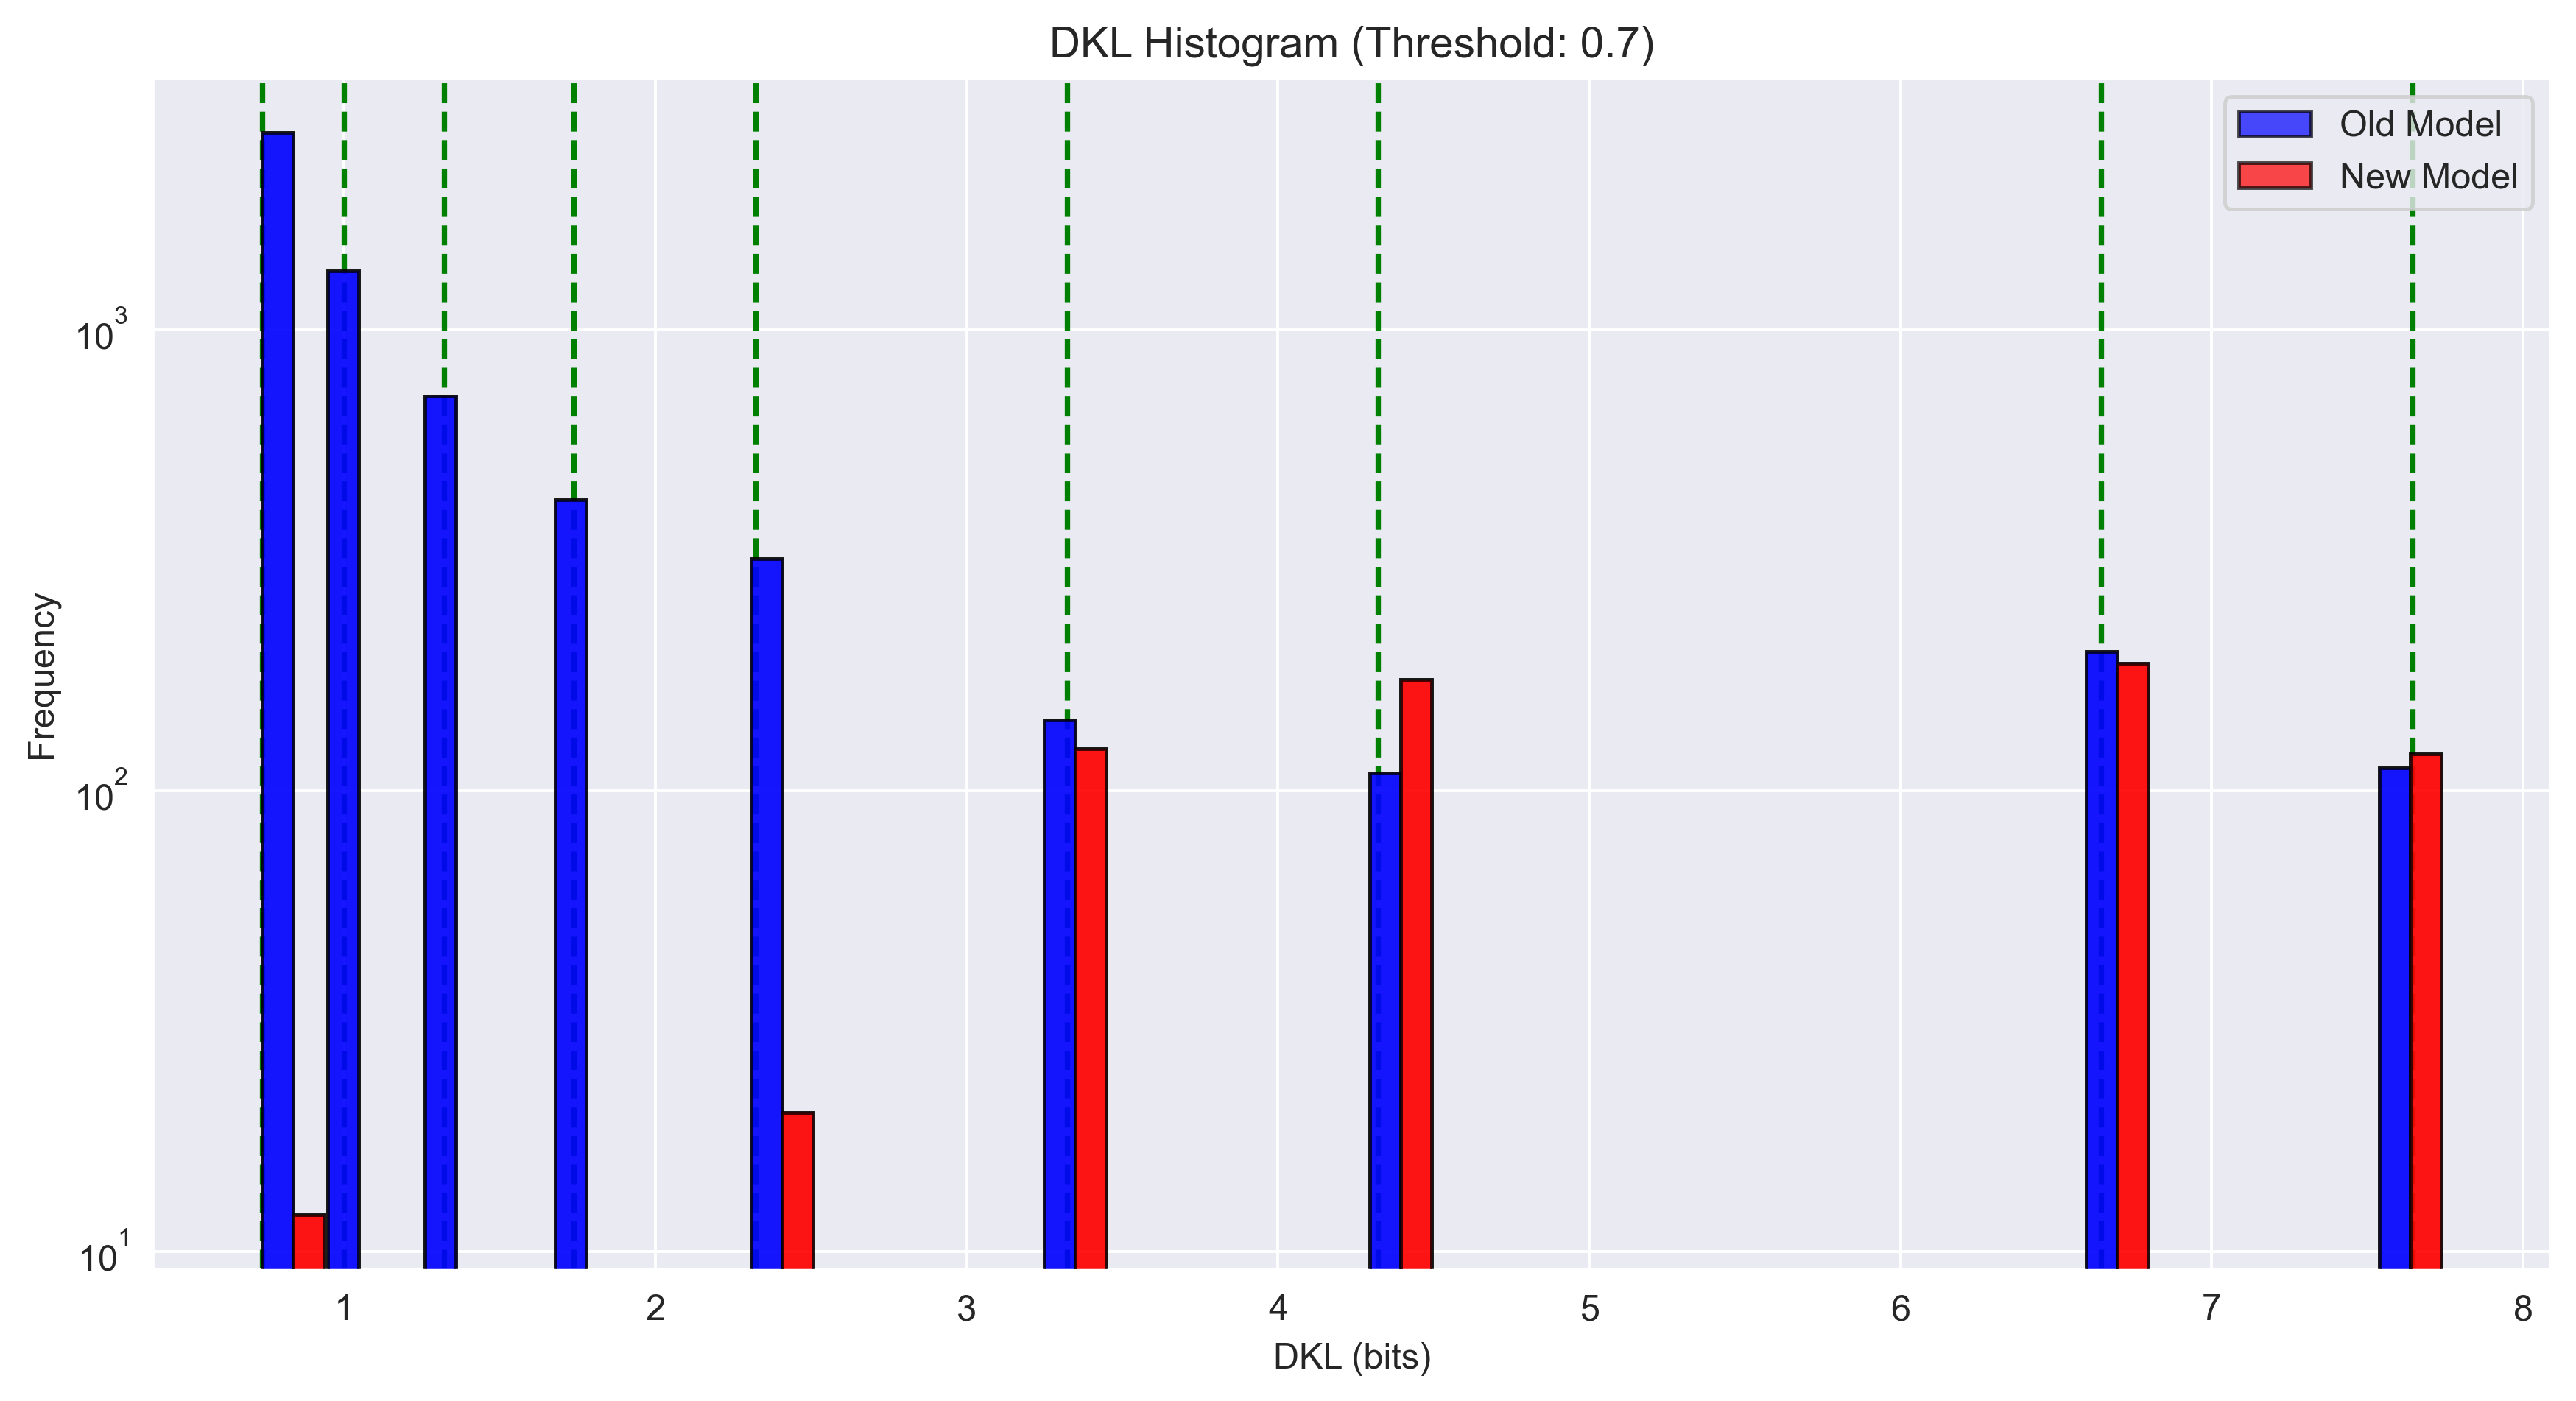

In [75]:


# Plot the histograms for the old and new models with threshold = 0
# plot_histograms_on_same_axes(dkl_old, dkl_new, 0, 'DKL Histogram')

# Plot the histograms for the old and new models with threshold = 0.7
plot_histograms_on_same_axes(dkl_old, dkl_new, 0.7, 'DKL Histogram')

So
* You can see how a small number of outliers can really affect the information gain

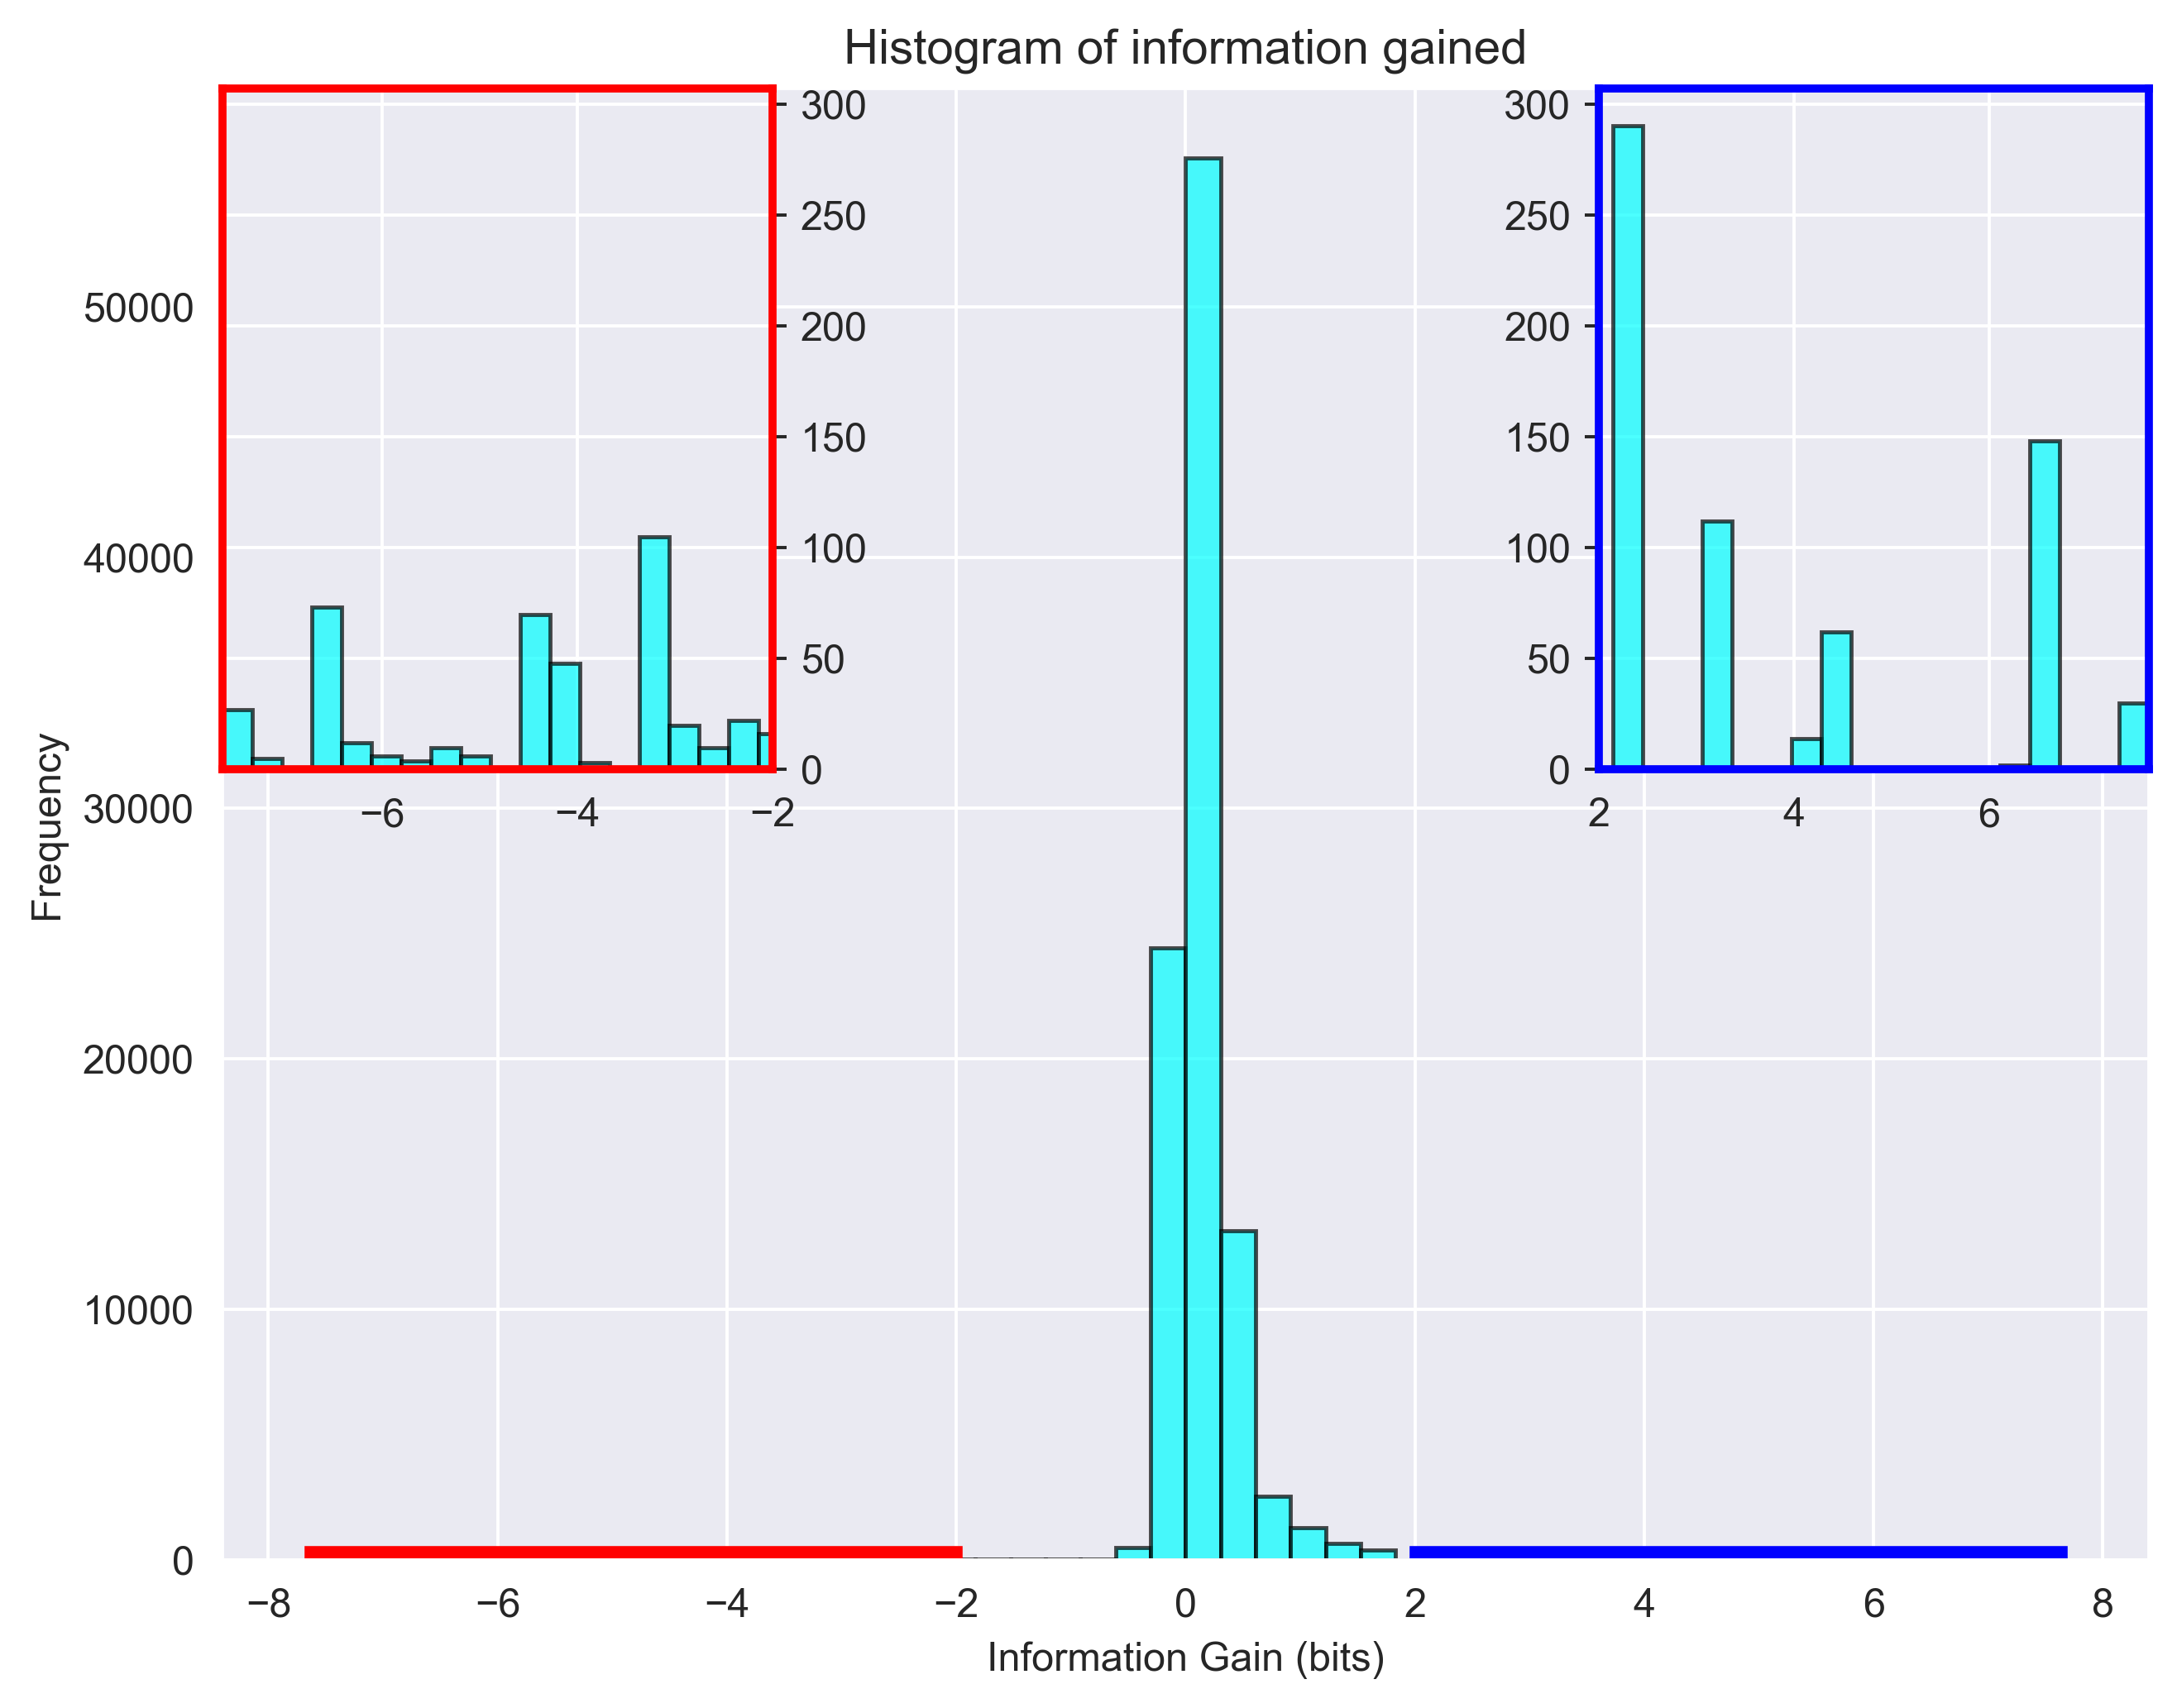

In [76]:
plot_histogram_with_insets(ig)